# Анализ данных молочного хозяйства 

**Описание проекта**

К нам обратился фермер, владелец молочного хозяйства. Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».
Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!

**Задача** - разработать модель машинного обучения, которая поможет управлять рисками и принимать объективное решение о покупке коров. 
Нужно создать две прогнозные модели для отбора бурёнок в поголовье:
- Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
- Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

С помощью модели нужно отобрать коров по двум критериям:
- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным.

**Описание данных:**
Описание данных:

Файл содержит данные о стаде фермера на текущий момент. 
- id — уникальный идентификатор коровы.
- Удой, кг (milk_yield_kg)— масса молока, которую корова даёт в год (в килограммах). 
- ЭКЕ (Энергетическая кормовая единица) (energy_feed_unit)— показатель питательности корма коровы. 
- Сырой протеин, г (crude_protein_g) — содержание сырого протеина в корме (в граммах). 
- СПО (Сахаро-протеиновое соотношение) (sugar_protein_ratio) — отношение сахара к протеину в корме коровы. 
- Порода (cow_breed) — порода коровы. 
- Тип пастбища (pasture_type) — ландшафт лугов, на которых паслась корова. 
- порода папы_быка (dad_breed) — порода папы коровы. 
- Жирность,% (fat_percentage)— содержание жиров в молоке (в процентах). 
- Белок,%, (protein_percentage) — содержание белков в молоке (в процентах). protein_percentage
- Вкус молока (taste) — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
- Возраст (age) — возраст коровы, бинарный признак (менее_2_лет, более_2_лет). 

Признаки в **ferma_main** можно разделить на группы.
- Характеристики коровы: id, Порода, порода папы_быка, Возраст.
- Характеристики корма: ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г, СПО (Сахаро-протеиновое соотношение).
- Характеристика пастбища: Тип пастбища.
- Характеристики молока: Удой, кг, Жирность,%, Белок,%, Вкус молока.

Файл **ferma_dad** хранит имя папы каждой коровы в стаде фермера. Описание данных:
- id — уникальный идентификатор коровы.
- Имя Папы (dad_name) — имя папы коровы.

Файл **cow_buy** — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. Описание данных:
- Порода (cow_breed) — порода коровы.
- Тип пастбища (pasture_type) — ландшафт лугов, на которых паслась корова.
- порода папы_быка (dad_breed) — порода папы коровы.
- Имя_папы (dad_name) — имя папы коровы.
- Текущая_жирность,% (fat_percentage) — содержание жиров в молоке (в процентах).
- Текущий_уровень_белок,% (protein_percentage) — содержание белков в молоке (в процентах).
- Возраст (age) — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

## 1. Загрузка данных

### 1.1 Загрузка и предварительный анализ данных фермы

In [1]:
#установки
!pip install -U scikit-learn 
!pip install shap
!pip install phik

In [2]:
#Импорт библиотек для работы с данными
import pandas as pd
import numpy as np

#Импорт библиотек для визуализации
from matplotlib import pyplot as plt
import seaborn as sns

#Импорт библиотек для машинного обучения и обработки данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import r2_score as sklearn_r2_score

#Импорт дополнительных библиотек
import phik
import shap

Заменим запятые в числовых данных на точки

In [4]:
#выведем 5 первых строк полученного датафрейма на экран
ferma.head()

id  Удой, кг  ЭКЕ (Энергетическая кормовая единица)  Сырой протеин, г  \
0   1      5863                                   14.2              1743   
1   2      5529                                   12.8              2138   
2   3      5810                                   14.0              1854   
3   4      5895                                   12.4              2012   
4   5      5302                                   12.8              1675   

   СПО (Сахаро-протеиновое соотношение)           Порода Тип пастбища  \
0                                 0.890   Вис Бик Айдиал    Равнинное   
1                                 0.890   Вис Бик Айдиал    Равнинные   
2                                 0.885  РефлешнСоверинг    Холмистое   
3                                 0.885  РефлешнСоверинг    Холмистое   
4                                 0.885   Вис Бик Айдиал    Равнинные   

  порода папы_быка  Жирность,%  Белок,% Вкус молока      Возраст  
0           Айдиал        3.58    3.076      вкусно  более_2_лет  
1          Соверин        3.54    3.079      вкусно  менее_2_лет  
2          Соверин        3.59    3.074   не вкусно  более_2_лет  
3           Айдиал        3.40    3.075   не вкусно  более_2_лет  
4          Соверин        3.73    3.073      вкусно  менее_2_лет

In [5]:
#посмотрим информацию о датафрейме
ferma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

Данные представляют собой таблицу с 634 записями и 12 столбцами.Три столбца имеют числовой тип данных (int64), остальные девять - строковый тип данных (object).

Исходя из полученных данных, можно отметить следующие проблемы в данном датасете: 1) числовые данные в столбцах: ЭКЕ (Энергетическая кормовая единица),  СПО (Сахаро-протеиновое соотношение), Жирность, Белок и возраст представлены как object. 2) названия столбцов стилистически неправильные. Однако, можно отметить, что в датасете отсутствуют пропуски. 

In [6]:
#посмотрим на количество пропущенных значений для каждого столбца
ferma.isna().sum()

id                                       0
Удой, кг                                 0
ЭКЕ (Энергетическая кормовая единица)    0
Сырой протеин, г                         0
СПО (Сахаро-протеиновое соотношение)     0
Порода                                   0
Тип пастбища                             0
порода папы_быка                         0
Жирность,%                               0
Белок,%                                  0
Вкус молока                              0
Возраст                                  0
dtype: int64

Действительно, пропусков в данном датасете нет

Теперь посмотрим на данные двух других датафреймов

In [8]:
#загрузим первые 5 строк полученного датафрейма
ferma_dad.head()

id  Имя Папы
0   1    Буйный
1   2  Соловчик
2   3     Барин
3   4    Буйный
4   5     Барин

In [9]:
#посмотрим на общую информацию о датафрейме
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


Данные представляют собой таблицу с 629 записями и 2 столбцами. Столбцы включают: уникальный идентификатор (id) и имя отца быка (Имя Папы). Один столбец имеет числовой тип данных (int64), а другой - строковый тип данных (object).

Можно отметить, что в данном датафрейме отсутствуют пропуски. Тип данных каждого столбца соответствует их содержимому. Единственное, нужно будет привести к правильному стилю названия столбцов

In [10]:
#выведем количество пропущенных значений для каждого столбца
ferma_dad.isna().sum()

id          0
Имя Папы    0
dtype: int64

Пропусков действительно не обнаружено

### 1.2 Загрузка и предварительный анализ данных ассоциации пастбищ "Экоферма"

In [12]:
#загрузим первые 5 строк полученного датафрейма
cow_buy.head()

Порода Тип пастбища порода папы_быка  Имя_папы  \
0   Вис Бик Айдиал    холмистое           Айдиал  Геркулес   
1   Вис Бик Айдиал    равнинное          Соверин    Буйный   
2  РефлешнСоверинг    равнинное          Соверин     Барин   
3  РефлешнСоверинг    холмистое           Айдиал    Буйный   
4  РефлешнСоверинг    равнинное           Айдиал    Буйный   

   Текущая_жирность,%  Текущий_уровень_белок,%      Возраст  
0                3.58                    3.076  более_2_лет  
1                3.54                    3.081  менее_2_лет  
2                3.59                    3.074  более_2_лет  
3                3.40                    3.061  более_2_лет  
4                3.64                    3.074  более_2_лет

In [13]:
#посмотрим на общую информацию о датафрейме
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Данные представляют собой таблицу с 20 записями и 7 столбцами. Можно отметить что каждый тип данных каждого столбца данного датафрейма указан как 'object', хотя в столбцах: текущая жирность, текущий уровень белок представлены числовые данные. Это нужно будет исправить на этапе предобработки данных. Также нужно будет исправить названия столбцов. 

In [14]:
#выведем количество пропущенных значений для каждого столбца
cow_buy.isna().sum()

Порода                     0
Тип пастбища               0
порода папы_быка           0
Имя_папы                   0
Текущая_жирность,%         0
Текущий_уровень_белок,%    0
Возраст                    0
dtype: int64

Пропусков в данном датафрейме не выявлено

**Вывод**: Были загружены и предварительно проанализированы данные 3-х датафремов. В результате выявлено, что данные содержат некорректные наименования столбцов, типы данных, которые нужно будет исправить на следующем этапе предобработки данных. 

##  2. Предобработка данных

### 2.1 Исправление наименований столбцов

Посмотрим для начала на названия столбцов в датафрейме ferma

In [15]:
#выведем первые 5 строк датафрейма на экран
ferma.head()

id  Удой, кг  ЭКЕ (Энергетическая кормовая единица)  Сырой протеин, г  \
0   1      5863                                   14.2              1743   
1   2      5529                                   12.8              2138   
2   3      5810                                   14.0              1854   
3   4      5895                                   12.4              2012   
4   5      5302                                   12.8              1675   

   СПО (Сахаро-протеиновое соотношение)           Порода Тип пастбища  \
0                                 0.890   Вис Бик Айдиал    Равнинное   
1                                 0.890   Вис Бик Айдиал    Равнинные   
2                                 0.885  РефлешнСоверинг    Холмистое   
3                                 0.885  РефлешнСоверинг    Холмистое   
4                                 0.885   Вис Бик Айдиал    Равнинные   

  порода папы_быка  Жирность,%  Белок,% Вкус молока      Возраст  
0           Айдиал        3.58    3.076      вкусно  более_2_лет  
1          Соверин        3.54    3.079      вкусно  менее_2_лет  
2          Соверин        3.59    3.074   не вкусно  более_2_лет  
3           Айдиал        3.40    3.075   не вкусно  более_2_лет  
4          Соверин        3.73    3.073      вкусно  менее_2_лет

Названия столбцов у нас указаны на кириллице, за исключением id, где-то начинается с прописной, где-то со строчной. 
Предлагаю все привести к одному виду: название написать на английском языке, привести все к нижнему регистру, разделить слова с помощью нижнего подчеркивания. 

In [16]:
#поправим названия столбцов
ferma = ferma.rename(columns={'Удой, кг':'milk_yield_kg', 'ЭКЕ (Энергетическая кормовая единица)':'energy_feed_unit', 'Сырой протеин, г':'crude_protein_g', 'СПО (Сахаро-протеиновое соотношение)':'sugar_protein_ratio','Порода':'cow_breed','Тип пастбища':'pasture_type','порода папы_быка':'dad_breed','Жирность,%':'fat_percentage','Белок,%':'protein_percentage','Вкус молока':'taste','Возраст':'age'})

In [17]:
#посмотрим, что получилось
ferma.head()

id  milk_yield_kg  energy_feed_unit  crude_protein_g  sugar_protein_ratio  \
0   1           5863              14.2             1743                0.890   
1   2           5529              12.8             2138                0.890   
2   3           5810              14.0             1854                0.885   
3   4           5895              12.4             2012                0.885   
4   5           5302              12.8             1675                0.885   

         cow_breed pasture_type dad_breed  fat_percentage  protein_percentage  \
0   Вис Бик Айдиал    Равнинное    Айдиал            3.58               3.076   
1   Вис Бик Айдиал    Равнинные   Соверин            3.54               3.079   
2  РефлешнСоверинг    Холмистое   Соверин            3.59               3.074   
3  РефлешнСоверинг    Холмистое    Айдиал            3.40               3.075   
4   Вис Бик Айдиал    Равнинные   Соверин            3.73               3.073   

       taste          age  
0     вкусно  более_2_лет  
1     вкусно  менее_2_лет  
2  не вкусно  более_2_лет  
3  не вкусно  более_2_лет  
4     вкусно  менее_2_лет

Теперь названия столбцов выглядят стилистически правильными. Для удобства новые названия были также были добавлены в описание данных к проекту (в начале тетради)

Приведем данные столбца в колонке pasture_type к нижнему регистру. Это нужно будет в дальнейшем для соответствия данных в датасете ferma датасету cow_buy

In [18]:
#Приведем данные столбца в колонке pasture_type к нижнему регистру
ferma['pasture_type'] = ferma['pasture_type'].str.lower()

In [19]:
#посмотрим, что получилось
ferma.head()

id  milk_yield_kg  energy_feed_unit  crude_protein_g  sugar_protein_ratio  \
0   1           5863              14.2             1743                0.890   
1   2           5529              12.8             2138                0.890   
2   3           5810              14.0             1854                0.885   
3   4           5895              12.4             2012                0.885   
4   5           5302              12.8             1675                0.885   

         cow_breed pasture_type dad_breed  fat_percentage  protein_percentage  \
0   Вис Бик Айдиал    равнинное    Айдиал            3.58               3.076   
1   Вис Бик Айдиал    равнинные   Соверин            3.54               3.079   
2  РефлешнСоверинг    холмистое   Соверин            3.59               3.074   
3  РефлешнСоверинг    холмистое    Айдиал            3.40               3.075   
4   Вис Бик Айдиал    равнинные   Соверин            3.73               3.073   

       taste          age  
0     вкусно  более_2_лет  
1     вкусно  менее_2_лет  
2  не вкусно  более_2_лет  
3  не вкусно  более_2_лет  
4     вкусно  менее_2_лет

Теперь посмотрим на второй датафрейм

In [20]:
#выведем первые 5 строк датафрейма на экран
ferma_dad.head()

id  Имя Папы
0   1    Буйный
1   2  Соловчик
2   3     Барин
3   4    Буйный
4   5     Барин

Тут также стоит поправить названия столбца "Имя Папы"

In [21]:
#поправим название столбца с именем отца коровы
ferma_dad = ferma_dad.rename(columns={'Имя Папы':'dad_name'})

In [22]:
#посмотрим, что получилось
ferma_dad.head()

id  dad_name
0   1    Буйный
1   2  Соловчик
2   3     Барин
3   4    Буйный
4   5     Барин

И наконец, поправим третий датафрейм с данными Экофермы

In [23]:
#выведем первые 5 строк датафрейма на экран
cow_buy.head()

Порода Тип пастбища порода папы_быка  Имя_папы  \
0   Вис Бик Айдиал    холмистое           Айдиал  Геркулес   
1   Вис Бик Айдиал    равнинное          Соверин    Буйный   
2  РефлешнСоверинг    равнинное          Соверин     Барин   
3  РефлешнСоверинг    холмистое           Айдиал    Буйный   
4  РефлешнСоверинг    равнинное           Айдиал    Буйный   

   Текущая_жирность,%  Текущий_уровень_белок,%      Возраст  
0                3.58                    3.076  более_2_лет  
1                3.54                    3.081  менее_2_лет  
2                3.59                    3.074  более_2_лет  
3                3.40                    3.061  более_2_лет  
4                3.64                    3.074  более_2_лет

Поступим также, как и в первой таблице с данными фермы заказчика

In [24]:
#поправим названия столбцов
cow_buy = cow_buy.rename(columns={'Порода':'cow_breed','Тип пастбища':'pasture_type', 'порода папы_быка':'dad_breed', 'Имя_папы':'dad_name', 'Текущая_жирность,%':'fat_percentage','Текущий_уровень_белок,%':'protein_percentage', 'Возраст':'age'})

In [25]:
#проверим, что получилось
cow_buy.head()

cow_breed pasture_type dad_breed  dad_name  fat_percentage  \
0   Вис Бик Айдиал    холмистое    Айдиал  Геркулес            3.58   
1   Вис Бик Айдиал    равнинное   Соверин    Буйный            3.54   
2  РефлешнСоверинг    равнинное   Соверин     Барин            3.59   
3  РефлешнСоверинг    холмистое    Айдиал    Буйный            3.40   
4  РефлешнСоверинг    равнинное    Айдиал    Буйный            3.64   

   protein_percentage          age  
0               3.076  более_2_лет  
1               3.081  менее_2_лет  
2               3.074  более_2_лет  
3               3.061  более_2_лет  
4               3.074  более_2_лет

Теперь названия столбцов для всех 3-х датафреймов выглядят стилистически правильными

### 2.2 Изменение типа данных

Согласно предварительному анализу данных, в датафрейме ferma в колонках: 'energy_feed_unit', 'sugar_protein_ratio', 'fat_percentage' и	'protein_percentage' тип данных заявлен как object, хотя в данных столбцах представлены числовые данные. Для дальнейшей работы с данными столбцами нужно преобразовать тип данных в int или float. Сделаем это с помощью метода astype()

In [26]:
#сохраним в columns_to_convert названия всех столбцов, тип данных которых хотим преобразовать
columns_to_convert = ['energy_feed_unit', 'sugar_protein_ratio', 'fat_percentage', 'protein_percentage']

In [27]:
# Преобразуем столбцы в тип float
ferma[columns_to_convert] = ferma[columns_to_convert].astype(float)

In [28]:
#выведем первые 5 строк датафрейма на экран
ferma.head()

id  milk_yield_kg  energy_feed_unit  crude_protein_g  sugar_protein_ratio  \
0   1           5863              14.2             1743                0.890   
1   2           5529              12.8             2138                0.890   
2   3           5810              14.0             1854                0.885   
3   4           5895              12.4             2012                0.885   
4   5           5302              12.8             1675                0.885   

         cow_breed pasture_type dad_breed  fat_percentage  protein_percentage  \
0   Вис Бик Айдиал    равнинное    Айдиал            3.58               3.076   
1   Вис Бик Айдиал    равнинные   Соверин            3.54               3.079   
2  РефлешнСоверинг    холмистое   Соверин            3.59               3.074   
3  РефлешнСоверинг    холмистое    Айдиал            3.40               3.075   
4   Вис Бик Айдиал    равнинные   Соверин            3.73               3.073   

       taste          age  
0     вкусно  более_2_лет  
1     вкусно  менее_2_лет  
2  не вкусно  более_2_лет  
3  не вкусно  более_2_лет  
4     вкусно  менее_2_лет

In [29]:
#проверим
ferma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   634 non-null    int64  
 1   milk_yield_kg        634 non-null    int64  
 2   energy_feed_unit     634 non-null    float64
 3   crude_protein_g      634 non-null    int64  
 4   sugar_protein_ratio  634 non-null    float64
 5   cow_breed            634 non-null    object 
 6   pasture_type         634 non-null    object 
 7   dad_breed            634 non-null    object 
 8   fat_percentage       634 non-null    float64
 9   protein_percentage   634 non-null    float64
 10  taste                634 non-null    object 
 11  age                  634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


Все данные успешно преобразованы

В датафрейме cow_buy нам нужно будет преобразовать только два столбца: fat_percentage и protein_percentage из типа данных object в float

In [30]:
#также сохраним в columns_to_convert2 названия всех столбцов, тип данных которых хотим преобразовать
columns_to_convert2  =['fat_percentage', 'protein_percentage']

In [31]:
#преобразуем из типа данных object в float
cow_buy[columns_to_convert2] = cow_buy[columns_to_convert2].astype(float)

In [32]:
#проверим что получилось
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cow_breed           20 non-null     object 
 1   pasture_type        20 non-null     object 
 2   dad_breed           20 non-null     object 
 3   dad_name            20 non-null     object 
 4   fat_percentage      20 non-null     float64
 5   protein_percentage  20 non-null     float64
 6   age                 20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Все данные успешно преобразованы

### 2.3 Определение наличия явных и неявных дубликатов

#### 2.3.1 Определения наличия явных дубликатов

In [33]:
#проверим наличие явных дубликатов в датафрейме ferma
ferma.duplicated().sum()

5

Обнаружено 5 явных дубликатов

In [34]:
#удалим обнаруженные дубликаты
ferma = ferma.drop_duplicates()

In [35]:
#проверим удалось ли удалить дубликаты
ferma.duplicated().sum()

0

In [36]:
#проверим наличие явных дубликатов в датафрейме ferma_dad
ferma_dad.duplicated().sum()

0

В датафрейме ferma_dad явных дубликатов не обнаружено

In [37]:
#проверим наличие явных дубликатов в датафрейме cow_buy
cow_buy.duplicated().sum()

4

In [38]:
#посмотрим на эти данные
cow_buy

cow_breed pasture_type dad_breed  dad_name  fat_percentage  \
0    Вис Бик Айдиал    холмистое    Айдиал  Геркулес            3.58   
1    Вис Бик Айдиал    равнинное   Соверин    Буйный            3.54   
2   РефлешнСоверинг    равнинное   Соверин     Барин            3.59   
3   РефлешнСоверинг    холмистое    Айдиал    Буйный            3.40   
4   РефлешнСоверинг    равнинное    Айдиал    Буйный            3.64   
5   РефлешнСоверинг    равнинное   Соверин  Геркулес            3.63   
6    Вис Бик Айдиал    холмистое    Айдиал  Геркулес            3.58   
7    Вис Бик Айдиал    равнинное   Соверин    Буйный            3.57   
8   РефлешнСоверинг    равнинное   Соверин     Барин            3.59   
9   РефлешнСоверинг    холмистое    Айдиал    Буйный            3.40   
10   Вис Бик Айдиал    холмистое   Соверин  Соловчик            3.73   
11  РефлешнСоверинг    равнинное   Соверин  Геркулес            3.73   
12   Вис Бик Айдиал    холмистое    Айдиал  Геркулес            3.68   
13   Вис Бик Айдиал    холмистое   Соверин     Барин            3.42   
14  РефлешнСоверинг    равнинное   Соверин     Барин            3.59   
15  РефлешнСоверинг    холмистое    Айдиал    Буйный            3.40   
16   Вис Бик Айдиал    холмистое   Соверин  Соловчик            3.73   
17  РефлешнСоверинг    равнинное   Соверин  Геркулес            3.77   
18   Вис Бик Айдиал    равнинное   Соверин    Буйный            3.34   
19  РефлешнСоверинг    равнинное    Айдиал    Буйный            3.64   

    protein_percentage          age  
0                3.076  более_2_лет  
1                3.081  менее_2_лет  
2                3.074  более_2_лет  
3                3.061  более_2_лет  
4                3.074  более_2_лет  
5                3.053  менее_2_лет  
6                3.076  более_2_лет  
7                3.079  более_2_лет  
8                3.074  более_2_лет  
9                3.079  менее_2_лет  
10               3.055  более_2_лет  
11               3.073  более_2_лет  
12               3.046  более_2_лет  
13               3.075  менее_2_лет  
14               3.074  более_2_лет  
15               3.065  более_2_лет  
16               3.079  более_2_лет  
17               3.053  менее_2_лет  
18               3.069  более_2_лет  
19               3.074  более_2_лет

Действительно, видим явные дубликаты

In [39]:
#удалим дубликаты
cow_buy = cow_buy.drop_duplicates()

In [40]:
#проверим наличие явных дубликатов в датафрейме cow_buy
cow_buy.duplicated().sum()

0

In [41]:
#посмотрим на эти данные
cow_buy

cow_breed pasture_type dad_breed  dad_name  fat_percentage  \
0    Вис Бик Айдиал    холмистое    Айдиал  Геркулес            3.58   
1    Вис Бик Айдиал    равнинное   Соверин    Буйный            3.54   
2   РефлешнСоверинг    равнинное   Соверин     Барин            3.59   
3   РефлешнСоверинг    холмистое    Айдиал    Буйный            3.40   
4   РефлешнСоверинг    равнинное    Айдиал    Буйный            3.64   
5   РефлешнСоверинг    равнинное   Соверин  Геркулес            3.63   
7    Вис Бик Айдиал    равнинное   Соверин    Буйный            3.57   
9   РефлешнСоверинг    холмистое    Айдиал    Буйный            3.40   
10   Вис Бик Айдиал    холмистое   Соверин  Соловчик            3.73   
11  РефлешнСоверинг    равнинное   Соверин  Геркулес            3.73   
12   Вис Бик Айдиал    холмистое    Айдиал  Геркулес            3.68   
13   Вис Бик Айдиал    холмистое   Соверин     Барин            3.42   
15  РефлешнСоверинг    холмистое    Айдиал    Буйный            3.40   
16   Вис Бик Айдиал    холмистое   Соверин  Соловчик            3.73   
17  РефлешнСоверинг    равнинное   Соверин  Геркулес            3.77   
18   Вис Бик Айдиал    равнинное   Соверин    Буйный            3.34   

    protein_percentage          age  
0                3.076  более_2_лет  
1                3.081  менее_2_лет  
2                3.074  более_2_лет  
3                3.061  более_2_лет  
4                3.074  более_2_лет  
5                3.053  менее_2_лет  
7                3.079  более_2_лет  
9                3.079  менее_2_лет  
10               3.055  более_2_лет  
11               3.073  более_2_лет  
12               3.046  более_2_лет  
13               3.075  менее_2_лет  
15               3.065  более_2_лет  
16               3.079  более_2_лет  
17               3.053  менее_2_лет  
18               3.069  более_2_лет

Таким образом, в датасете осталось 19 коров

#### 2.3.2 Определение наличия неявных дубликатов

Теперь проверим неявные дубликаты в датасете ferma

In [42]:
#Проверим комбинации столбцов на уникальность
duplicates = ferma[ferma.duplicated(subset=['cow_breed', 'milk_yield_kg', 'fat_percentage', 'protein_percentage', 'age'], keep=False)]

In [43]:
duplicates

Empty DataFrame
Columns: [id, milk_yield_kg, energy_feed_unit, crude_protein_g, sugar_protein_ratio, cow_breed, pasture_type, dad_breed, fat_percentage, protein_percentage, taste, age]
Index: []

нет дубликатов

In [44]:
#Проверим комбинации столбцов на уникальность
duplicates2 = ferma[ferma.duplicated(subset=['energy_feed_unit', 'crude_protein_g', 'sugar_protein_ratio', 'milk_yield_kg'], keep=False)]

In [45]:
duplicates2

Empty DataFrame
Columns: [id, milk_yield_kg, energy_feed_unit, crude_protein_g, sugar_protein_ratio, cow_breed, pasture_type, dad_breed, fat_percentage, protein_percentage, taste, age]
Index: []

нет дубликатов

Проверим неявные дубликаты в датасете cow_buy

In [46]:
#Проверим комбинации столбцов на уникальность
duplicates3 = cow_buy[cow_buy.duplicated(subset=['cow_breed', 'pasture_type', 'fat_percentage', 'protein_percentage', 'age'], keep=False)]

In [47]:
duplicates3

Empty DataFrame
Columns: [cow_breed, pasture_type, dad_breed, dad_name, fat_percentage, protein_percentage, age]
Index: []

нет дубликатов

#### 2.3.3 Анализ столбцов категориальных данных

Посмотрим на уникальные категориальные данные в датасете ferma

In [48]:
ferma['cow_breed'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

Судя по всему, коровы на ферме представлены только двумя породами 'Вис Бик Айдиал' и 'РефлешнСоверинг'. Проблем с данным столбцом нет

In [49]:
ferma['pasture_type'].unique()

array(['равнинное', 'равнинные', 'холмистое'], dtype=object)

Тут можно заметить что тип пастбищ "равнинное" записывается 2-мя вариантами : 'Равнинное', 'Равнинные'. Думаю, что это нужно исправить поскольку по сути это одна категория и ее не стоит разбивать на 2 части

In [50]:
#посмотрим сколько у нас данных по каждому типу пастбища
ferma.groupby('pasture_type')['id'].agg('count')

pasture_type
равнинное    253
равнинные     25
холмистое    351
Name: id, dtype: int64

Скорее всего в 25 записях ошиблись в написании названия типа пастбища. Поэтому исправим 'Равнинные' на  'Равнинное'

In [51]:
#сделаем эту замену
ferma['pasture_type'] = ferma['pasture_type'].replace('равнинные','равнинное')

In [52]:
#проверим уникальные данные после замены названия
ferma['pasture_type'].unique()

array(['равнинное', 'холмистое'], dtype=object)

Отлично теперь у нас два типа пастбища: Равнинное и Холмистое

In [53]:
#посмотрим что у нас со столбцом 'dad_breed'
ferma['dad_breed'].unique()

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

In [54]:
#посмотрим сколько у нас данных по каждому отцу
ferma.groupby('dad_breed')['id'].agg('count')

dad_breed
Айдиал     240
Айдиалл     78
Соверин    311
Name: id, dtype: int64

Тут вопрос, Айдиал и Айдиалл это один и тот же бык или два разных? Судя по всему это одна и таже порода быка. Поэтому обедими данные 'Айдиал' и 'Айдиалл' под одним названием 'Айдиал'

In [55]:
ferma['dad_breed']=ferma['dad_breed'].replace('Айдиалл','Айдиал')

In [56]:
#посмотрим что у нас получилось со столбцом 'dad_breed'
ferma['dad_breed'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

Все хорошо, теперь у нас 2 породы быка: 'Айдиал' и 'Соверин'

Теперь посмотрим, какие данные представлены в колонке с возрастом животного

In [57]:
ferma['age'].unique()

array(['более_2_лет', 'менее_2_лет'], dtype=object)

Тут всего 2 варианта: больше 2-х лет и менее

Посмотрим на категориальные данные датафрейма ferma_dad

In [58]:
ferma_dad['dad_name'].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

Тут все в порядке с данными

Теперь приступим к данным датафрейма cow_buy

In [59]:
cow_buy['pasture_type'].unique()

array(['холмистое', 'равнинное'], dtype=object)

In [60]:
cow_buy['dad_name'].unique()

array(['Геркулес', 'Буйный', 'Барин', 'Соловчик'], dtype=object)

In [61]:
cow_buy['dad_breed'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

In [62]:
cow_buy['age'].unique()

array(['более_2_лет', 'менее_2_лет'], dtype=object)

С категориальными данными датафрейма cow_buy все впорядке

## 3. Исследовательский анализ данных

### 3.1 Статистический анализ признаков

In [63]:
#выведем статистические данные по датасету ferma
ferma.describe()

id  milk_yield_kg  energy_feed_unit  crude_protein_g  \
count  629.00000     629.000000        629.000000       629.000000   
mean   315.00000    6188.750397         14.543879      1923.364070   
std    181.72094    1644.795489          1.306408       182.956251   
min      1.00000    5204.000000         10.900000      1660.000000   
25%    158.00000    5751.000000         13.500000      1771.000000   
50%    315.00000    6133.000000         14.700000      1888.000000   
75%    472.00000    6501.000000         15.600000      2062.000000   
max    629.00000   45616.000000         16.800000      2349.000000   

       sugar_protein_ratio  fat_percentage  protein_percentage  
count           629.000000      629.000000          629.000000  
mean              0.913116        3.603657            3.075671  
std               0.032203        0.168656            0.002549  
min               0.840000        2.990000            3.069000  
25%               0.890000        3.590000            3.074000  
50%               0.930000        3.650000            3.076000  
75%               0.940000        3.720000            3.077000  
max               0.960000        3.750000            3.085000

Рассмотрим полученные статистические результаты для каждого признака в нашем датасете ferma:
1) Удой (milk_yield_kg):
Средний удой составляет около 6188.75 кг в год.
Высокое стандартное отклонение (1644.80 кг) указывает на значительную вариацию в удоях.
Минимальное значение (5204 кг) и максимальное значение (45616 кг) предполагают наличие выбросов или ошибок в данных.

2) ЭКЕ (energy_feed_unit, crude_protein_g, sugar_protein_ratio):
Значения этих признаков варьируются в умеренных пределах.
Средняя питательность корма составляет 14.54 ЭКЕ, сырой протеин - 1923.36 г, а соотношение сахара к протеину - 0.913.

3) Качество молока (fat_percentage, protein_percentage):
Средняя жирность молока составляет 3.60%, а содержание белка - 3.08%.
Небольшое стандартное отклонение указывает на небольшую вариацию в этих показателях.

In [64]:
#выведем статистические данные по датасету cow_buy
cow_buy.describe()

fat_percentage  protein_percentage
count       16.000000           16.000000
mean         3.571875            3.068250
std          0.141620            0.011264
min          3.340000            3.046000
25%          3.415000            3.059500
50%          3.585000            3.073500
75%          3.692500            3.076750
max          3.770000            3.081000

Рассмотрим полученные статистические результаты для каждого признака в нашем датасете cow_buy:
1) fat_percentage имеет умеренную изменчивость и распределение значений близко к нормальному.

2) protein_percentage имеет очень низкую изменчивость и высокую однородность данных.

### 3.2 Визуализация и анализ количественных и категориальных признаков

#### 3.2.1 Анализ данных датасета ferma

In [65]:
#напишем функцию для построения гистограммы для каждого количественного признака
#сначала укажем, какие признаки у нас количественные
quantitative_columns = ['milk_yield_kg', 'energy_feed_unit', 'crude_protein_g', 'sugar_protein_ratio', 'fat_percentage', 'protein_percentage']

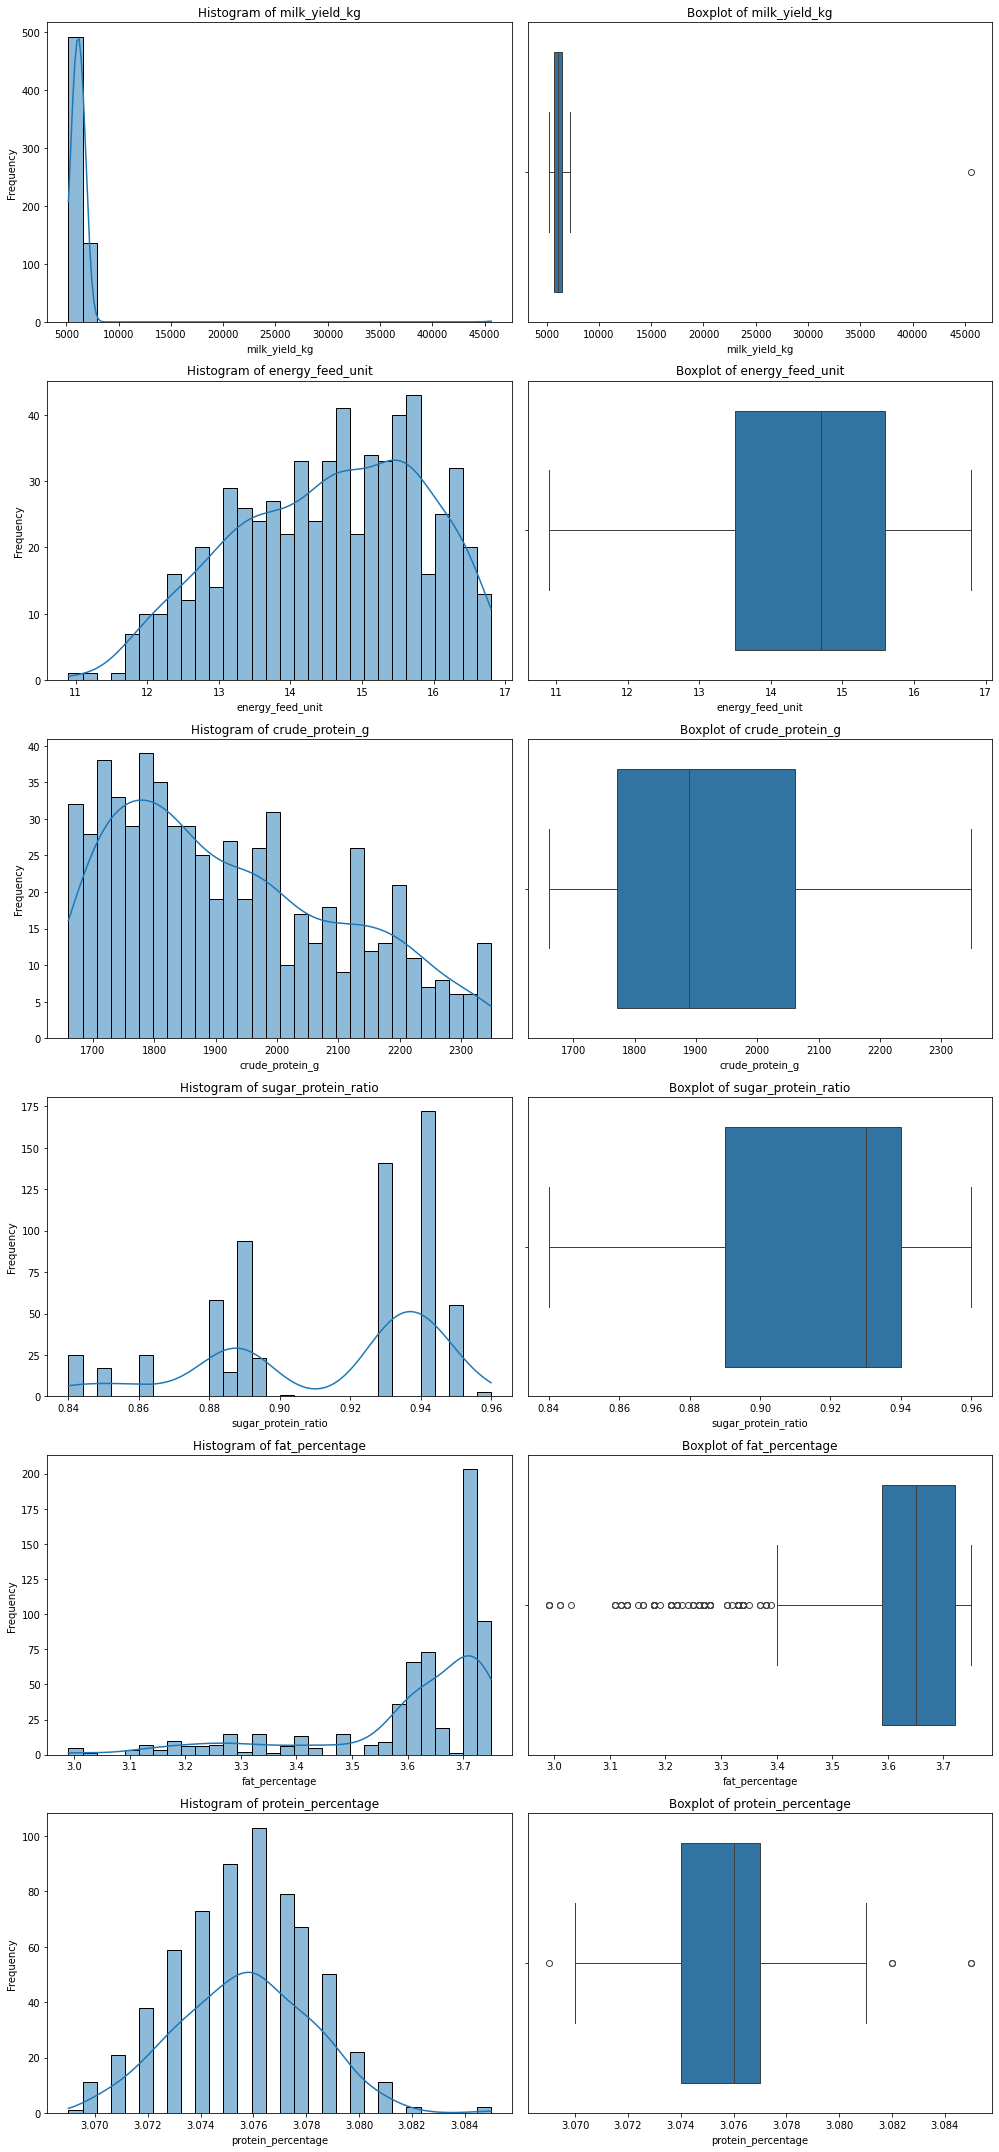

In [66]:
# Определяем количество строк и столбцов для подграфиков
num_features = len(quantitative_columns)
fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(14, num_features * 5))

# потроим графики
for i, column in enumerate(quantitative_columns):
    # Гистограмма
    sns.histplot(ferma[column], bins=30, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {column}')
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel('Frequency')
    
    # Боксплот
    sns.boxplot(x=ferma[column], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {column}')
    axes[i, 1].set_xlabel(column)

plt.tight_layout()
plt.show()

Исходя из полученных графиков, можно заметить явные выбросы в данных в столбцах 'milk_yieald_kg'. Также есть небольшая вариативность в данных 'fat_percentage' и 'protein_percentage'. В данном случае я бы удалила выбросы  в столбце 'milk_yieald_kg'

In [67]:
#удалим данные с milk_yieald_kg >7000
ferma = ferma.query('milk_yield_kg < 7000')

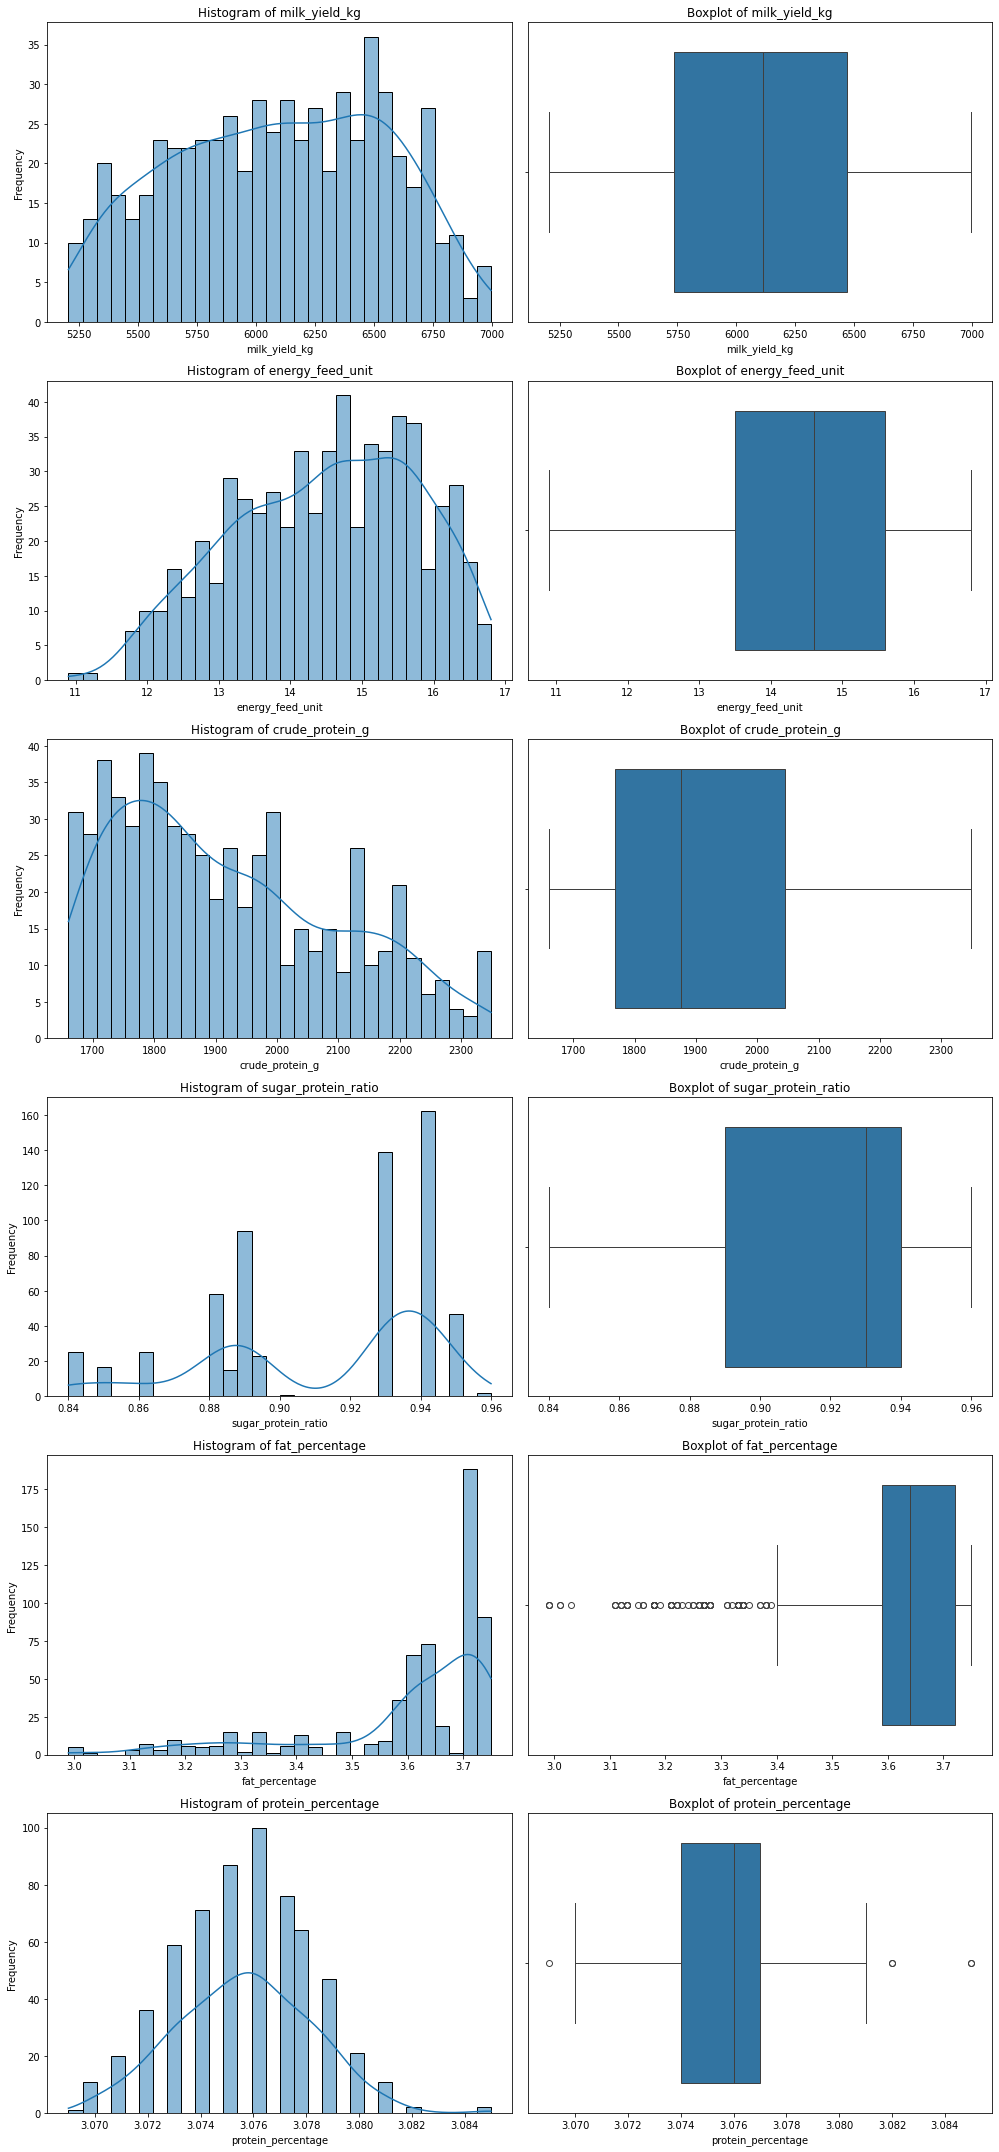

In [68]:
# Определяем количество строк и столбцов для подграфиков
num_features = len(quantitative_columns)
fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(14, num_features * 5))

# Построим графики
for i, column in enumerate(quantitative_columns):
    # Гистограмма
    sns.histplot(ferma[column], bins=30, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {column}')
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel('Frequency')
    
    # Боксплот
    sns.boxplot(x=ferma[column], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {column}')
    axes[i, 1].set_xlabel(column)

plt.tight_layout()
plt.show()

Теперь распределение данных в столбце 'milk_yield_kg' выглядит лучше. Но поскольку все данные представлены в разных данных, то перед моделирование нужно будет провести подготовку данных: масштабирование.

Также можно сказать о характере распределения данных: 1) Данные по удою молока. Данные по удою молока варьируются от 5250 до 7000 кг. Можно отметить отклонение от симметрии в данных, распределение скошено вправо с неявным пиком в 6500 кг. 2) данные по energy_feed_unit. Данные варьируются от 11 до 17 единиц. Можно отметить отклонение от симметрии в данных, распределение скошено вправо с неявным пиком в 15 единиц. 3) Данные по сырому протеину. Данные варьируются от 1660 до 2349. Можно отметить отклонение от симметрии в данных, распределение скошено влево с неявным пиком примерно в 1760 г. 4) Данные по отношению сахара к протеину. Данные варьируются от 0.84 до 0.96. Количество мод (пиков) в распределении - 2  (0.89 и 0.94). 5) Данные по жирности молока. Данные варьируются от 2.99 до 3.75%. Можно отметить отклонение от симметрии в данных, распределение скошено сильно вправо с  пиком в 3.7%. 6) Данные про содержанию протеина. Данные по содержанию протеина варьируются от 3.069 до 3.085%. Данные распределены симметрично с пиком 3.076%

далее приступим к категориальным признакам

In [69]:
#напишем функцию для построения гистограммы для каждого категориального признака
#сначала укажем, какие признаки у нас относятся к категориальным
categorical_columns = ['cow_breed','pasture_type', 'dad_breed', 'age', 'taste']

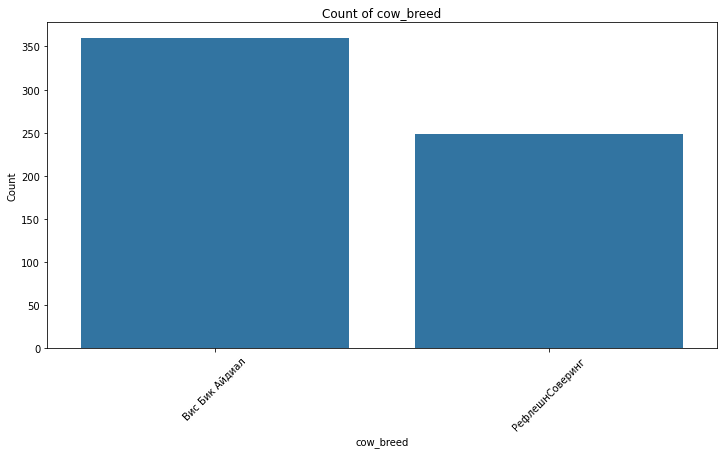

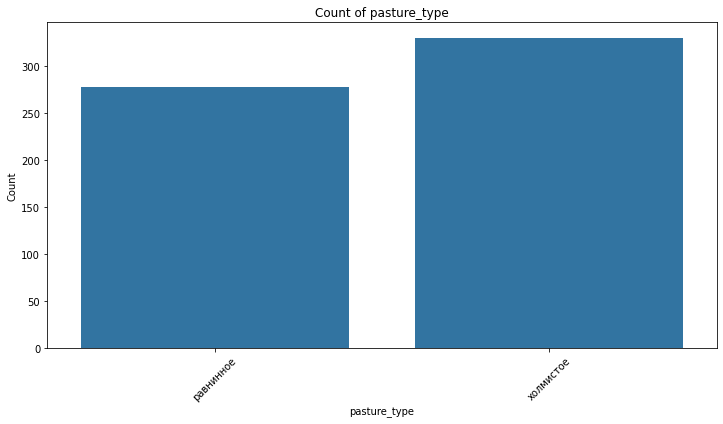

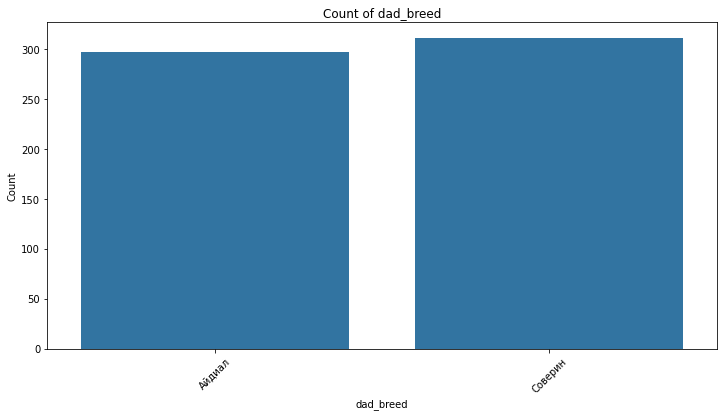

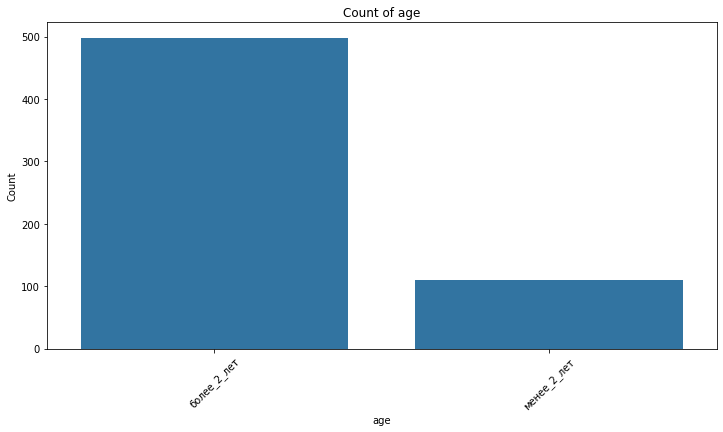

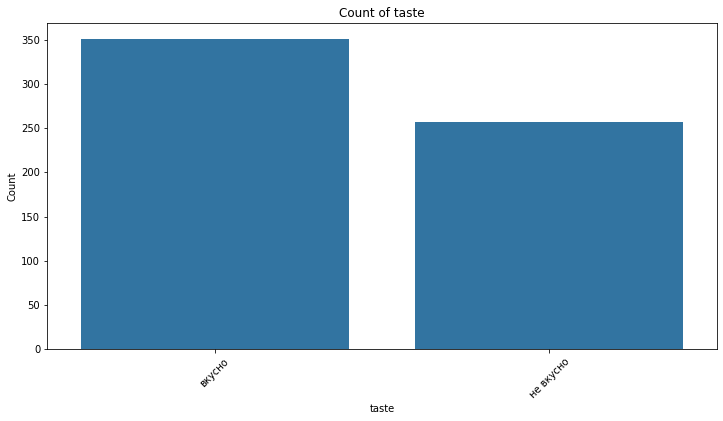

In [70]:
#функция для построения графиков для категориальных данных
for column in categorical_columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(x=column, data=ferma)
    plt.title(f'Count of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

Согласно полученным графикам можно отметить следующее: 1) Среди пород коров на ферме, преобладают представители породы Вис Бик Айдиал над РефлешнСоверинг 2) среди типа пастбищ преобладают холмистые над равнинными 3) количество коров от папы породы Айдиал примерно равно количеству коров от папы породы Соверин 4) Возраст большинства коров, представленных на ферме, более 2-х лет. 

#### 3.2 Анализ данных датасета cow_buy

Теперь посмотрим на данные датасета cow_buy

In [71]:
quantitative_columns2 = ['fat_percentage', 'protein_percentage']

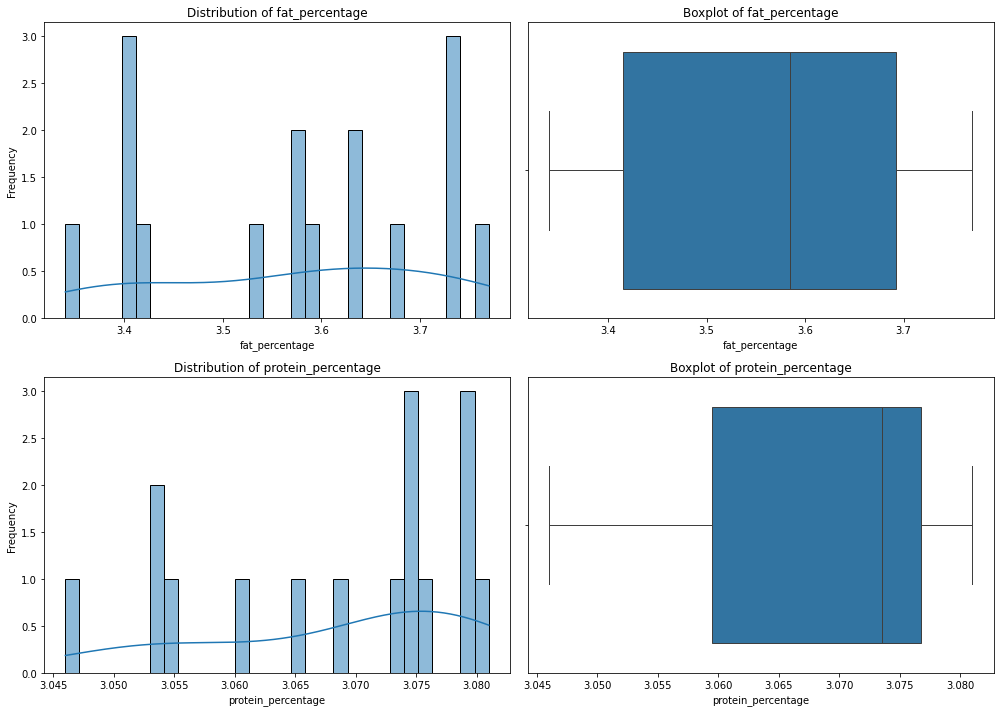

In [72]:
# Определяем количество строк и столбцов для подграфиков
num_features = len(quantitative_columns2)
fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(14, num_features * 5))

# Построим графики
for i, column in enumerate(quantitative_columns2):
    # Гистограмма
    sns.histplot(cow_buy[column], bins=30, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution of {column}')
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel('Frequency')
    
    # Боксплот
    sns.boxplot(x=cow_buy[column], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {column}')
    axes[i, 1].set_xlabel(column)

plt.tight_layout()
plt.show()

Согласно полученным графикам можно сказать следующее: 
1) fat_percentage имеет умеренную изменчивость и распределение значений близко к нормальному. Данные варьируются от 3.34 до 3.77%. Без явного пика

2) protein_percentage имеет очень низкую изменчивость и высокую однородность данных. Данные варьируются от 3.046 до 3.081%.  Можно отметить отклонение от симметрии в данных, распределение скошено сильно вправо с пиком в 3.075%. 

In [73]:
#построим графики для категориальных данных
#для начала выделим столбцы с категориальными признаками
categorical_columns2 = ['cow_breed', 'pasture_type', 'dad_breed', 'dad_name', 'age']

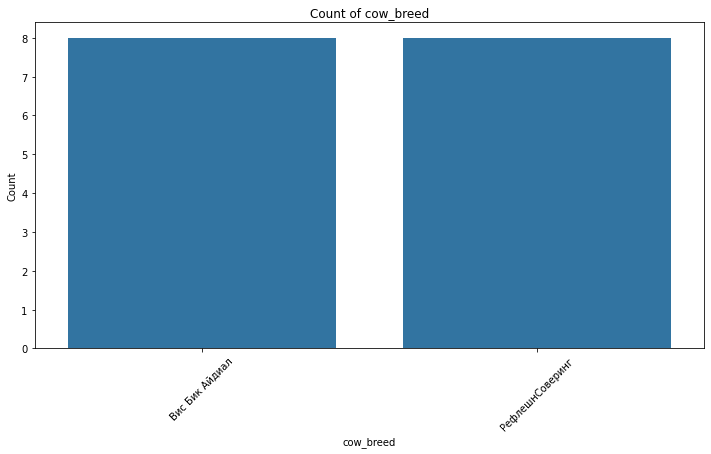

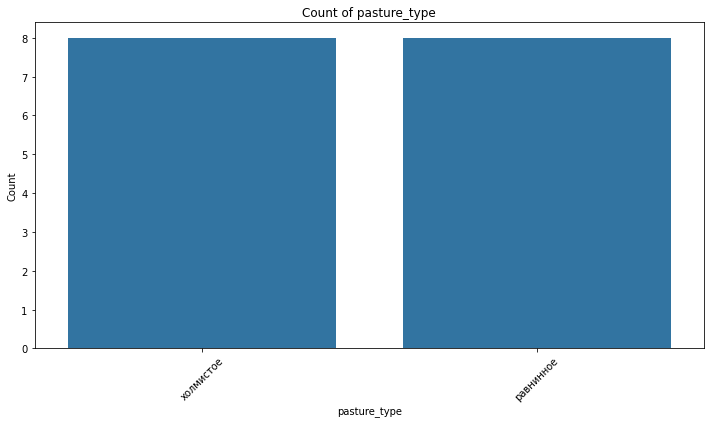

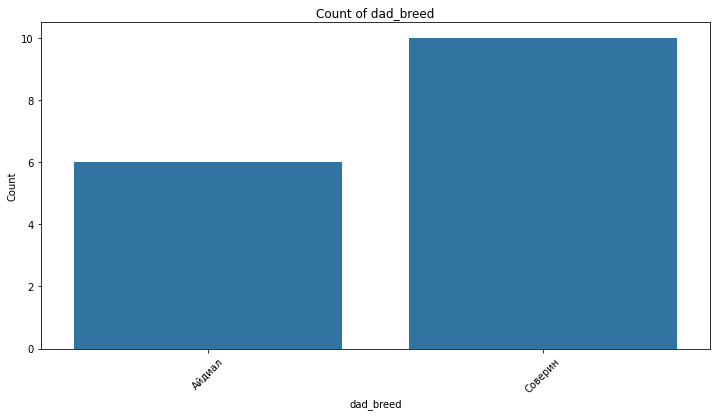

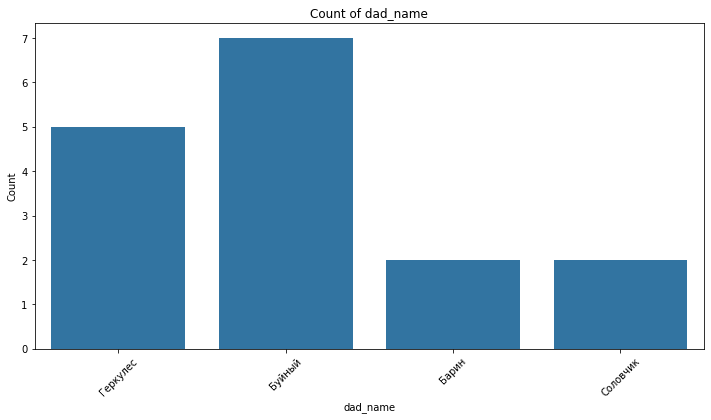

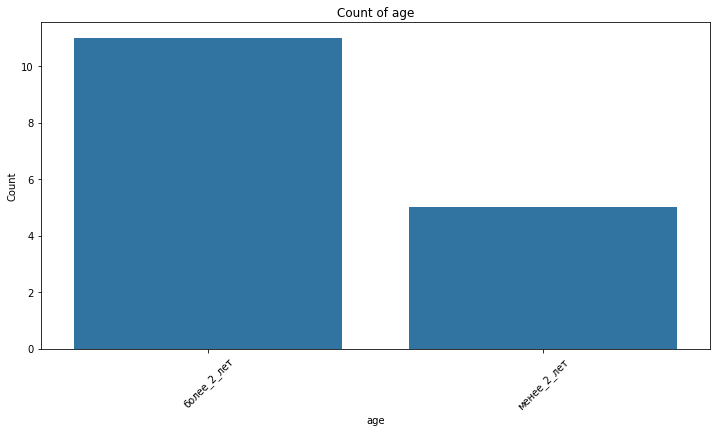

In [74]:
#напишем функцию для построения графика для категориальных признаков
for column in categorical_columns2:
        plt.figure(figsize=(12,6))
        sns.countplot(x=column, data = cow_buy)
        plt.title(f'Count of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation = 45)
        plt.show()

Согласно полученным графикам, можно сказать следующее: 1) на Экоферме представлено одинаковое количество коров пород Вис Бик Айдиал	 и РефлешнСоверинг, также и одинаковое количество коров с типом пастбища как равнинное, так и холмистое 2) большинство коров, представленных на Экоферме от папы породы Соверин 3) большинство коров от папы с именем "Буйный", чуть меньше от "Геркулеса" 4) Возраст большинства коров на Экоферме также более 2-х лет

## 4. Корреляционный анализ

### 4.1 Корреляционный анализ признаков датасета ferma. Матрица корреляции

Теперь рассмотрим взаимосвязи между признаками в датасете ferma

Поскольку распределение числовых данных ненормальное, можно использовать коэффициент корреляции Спирмена вместо Пирсона, так как он менее чувствителен к отклонениям от нормальности и выбросам.

In [75]:
# удалим нечисловые столбцы
numeric_ferma = ferma[quantitative_columns].copy()

In [76]:
# вычисление корреляционной матрицы с использованием Спирмена
correlation_matrix = numeric_ferma.corr(method='spearman')

In [77]:
correlation_matrix

milk_yield_kg  energy_feed_unit  crude_protein_g  \
milk_yield_kg             1.000000          0.749887         0.407175   
energy_feed_unit          0.749887          1.000000         0.353535   
crude_protein_g           0.407175          0.353535         1.000000   
sugar_protein_ratio       0.780740          0.730019         0.462000   
fat_percentage            0.693803          0.689728         0.381057   
protein_percentage       -0.018031         -0.028998         0.226796   

                     sugar_protein_ratio  fat_percentage  protein_percentage  
milk_yield_kg                   0.780740        0.693803           -0.018031  
energy_feed_unit                0.730019        0.689728           -0.028998  
crude_protein_g                 0.462000        0.381057            0.226796  
sugar_protein_ratio             1.000000        0.701509            0.100396  
fat_percentage                  0.701509        1.000000            0.033978  
protein_percentage              0.100396        0.033978            1.000000

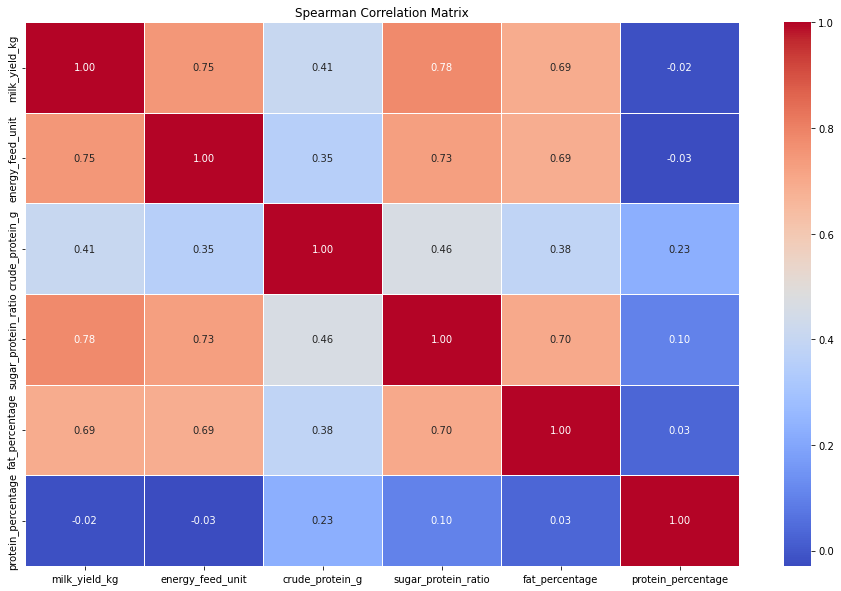

In [78]:
#построим тепловую карту для матрицы корреляции
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Spearman Correlation Matrix')
plt.show()

Согласно полученной матрице корреляции можно отметить следующее:
- Высокие положительные корреляции (например, между milk_yield_kg и energy_feed_unit или sugar_protein_ratio и fat_percentage) указывают на сильную положительную связь между этими признаками. Это означает, что увеличение одного признака связано с увеличением другого.
- Умеренные положительные корреляции (например, между milk_yield_kg и crude_protein_g) указывают на наличие положительной связи, но она не так сильна, как в предыдущем случае.
- Низкие или практически отсутствующие корреляции (например, между milk_yield_kg и protein_percentage) указывают на отсутствие значимой связи между этими признаками.

Признаков мультиколлинеарности не обнаружено

### 4.2 Анализ признаков датасета ferma. Связи в подгруппах

In [79]:
#сначала укажем, какие признаки у нас количественные
quantitative_columns = ['milk_yield_kg', 'energy_feed_unit', 'crude_protein_g', 'sugar_protein_ratio', 'fat_percentage', 'protein_percentage']
#также укажем, какие признаки у нас относятся к категориальным
categorical_columns = ['cow_breed','taste', 'pasture_type', 'dad_breed', 'age']

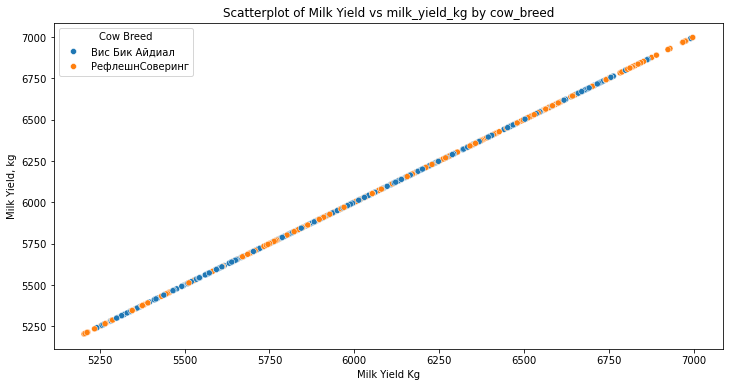

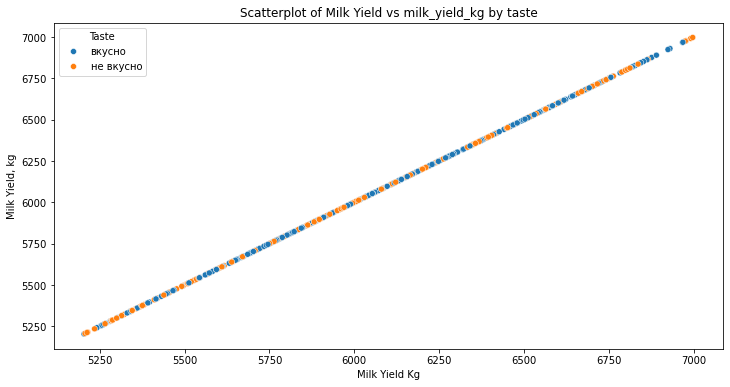

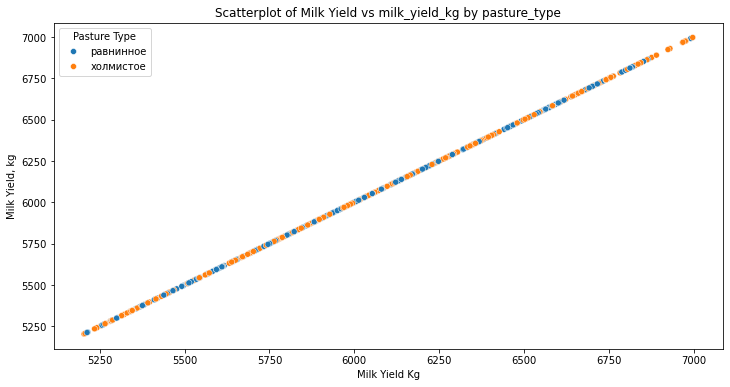

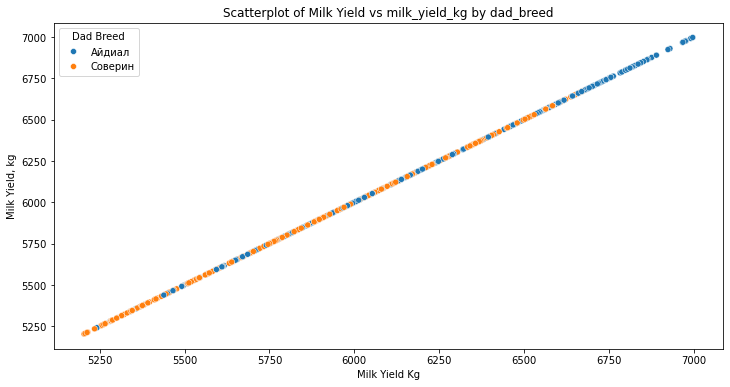

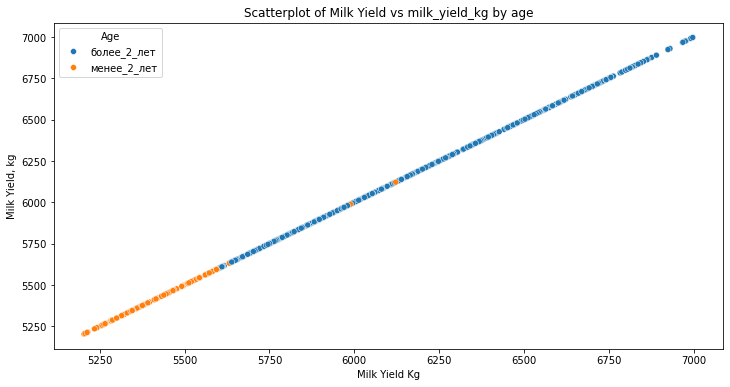

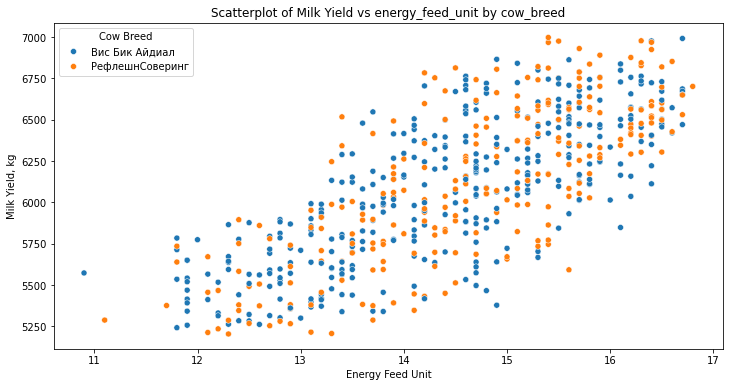

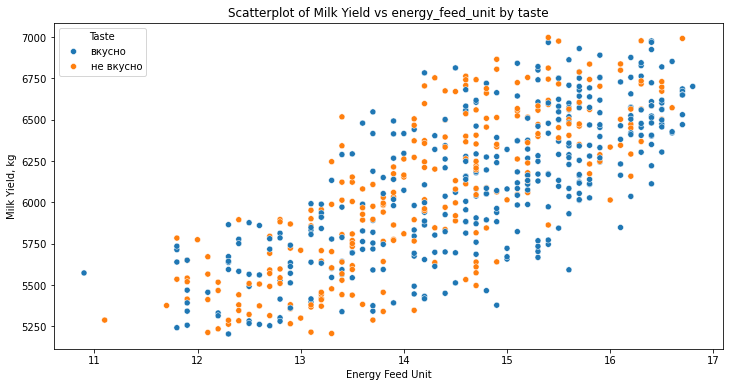

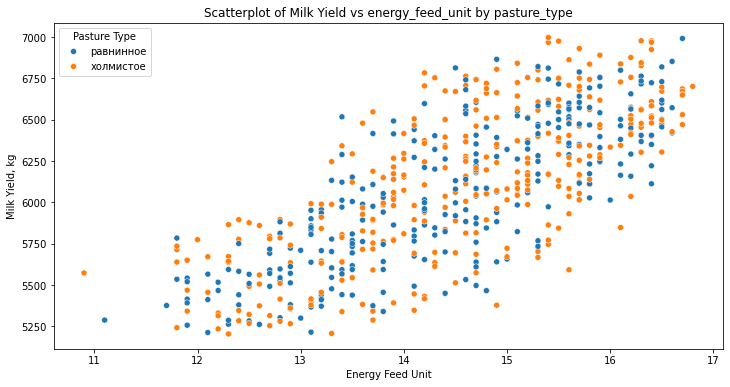

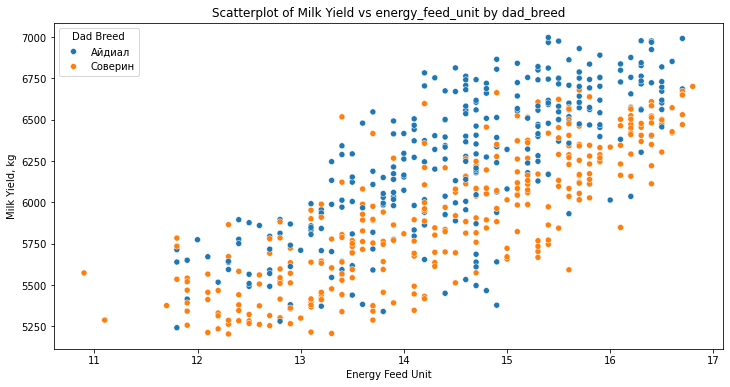

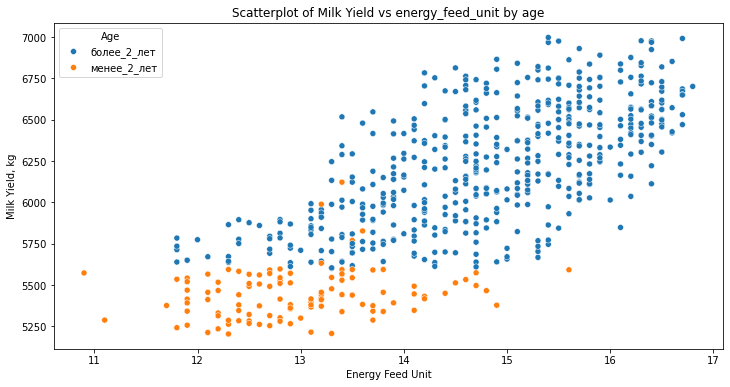

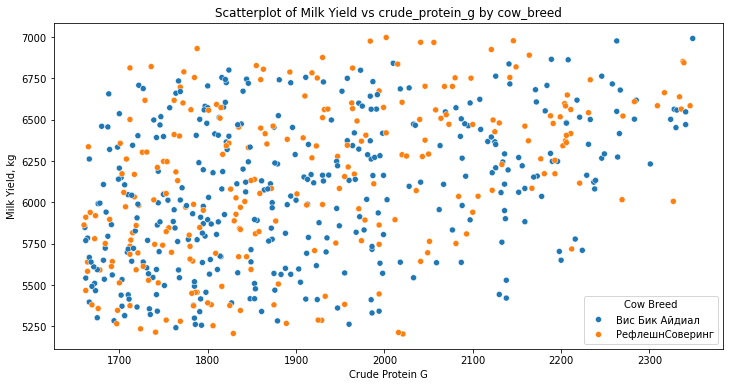

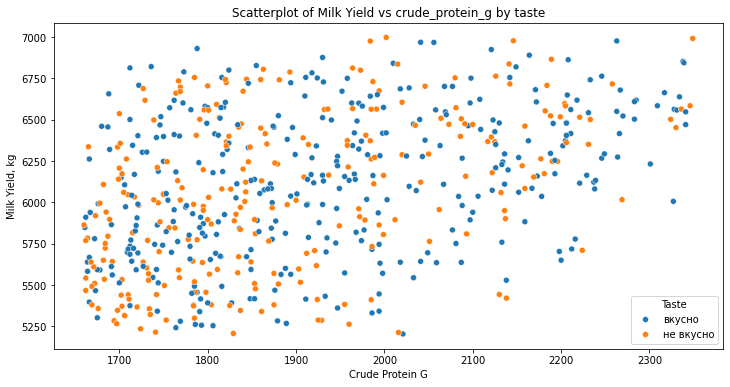

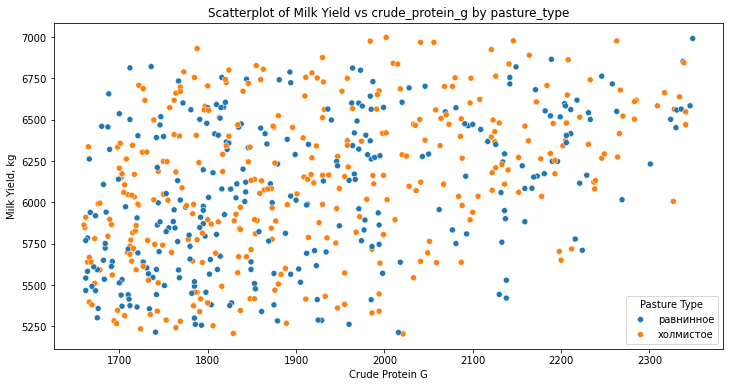

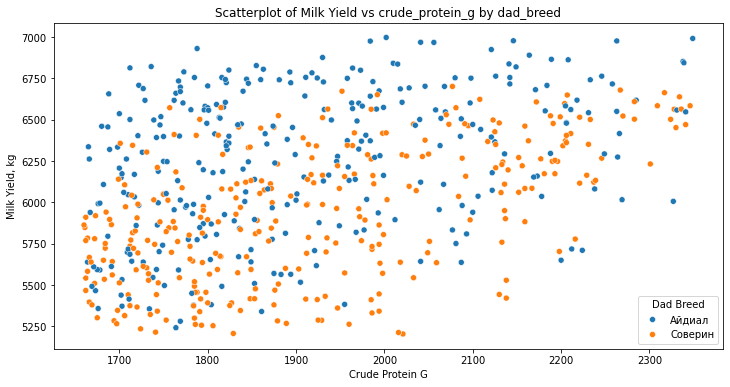

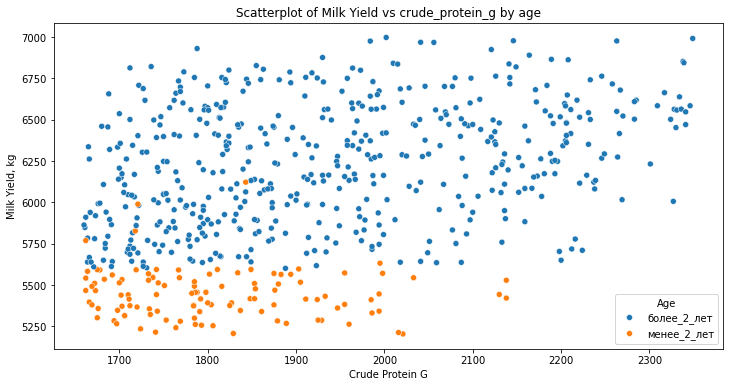

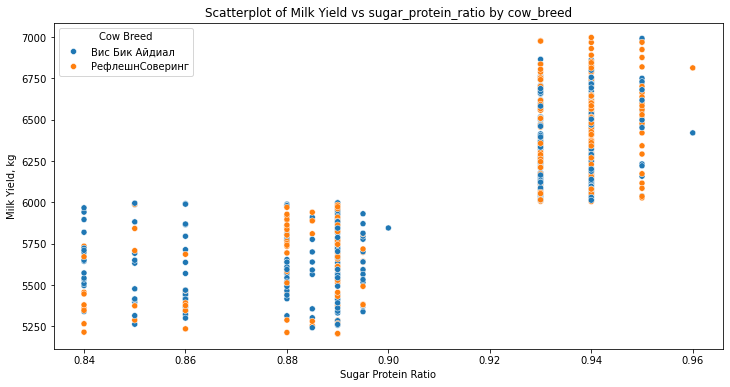

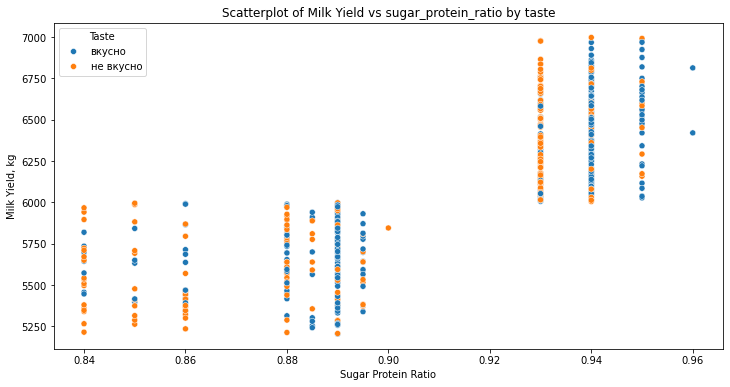

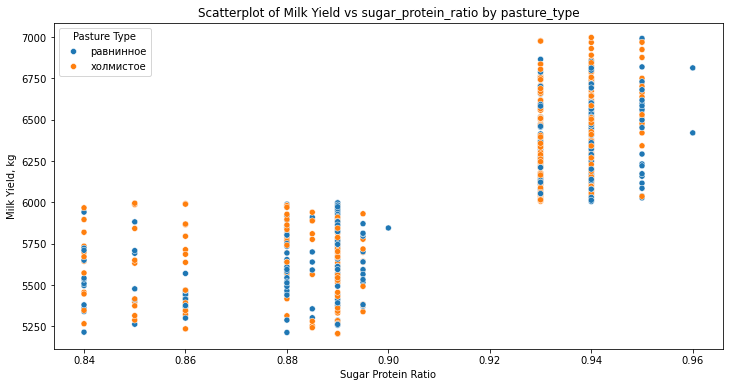

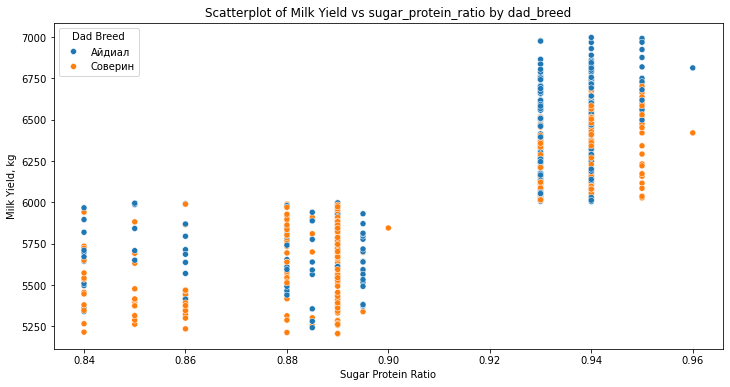

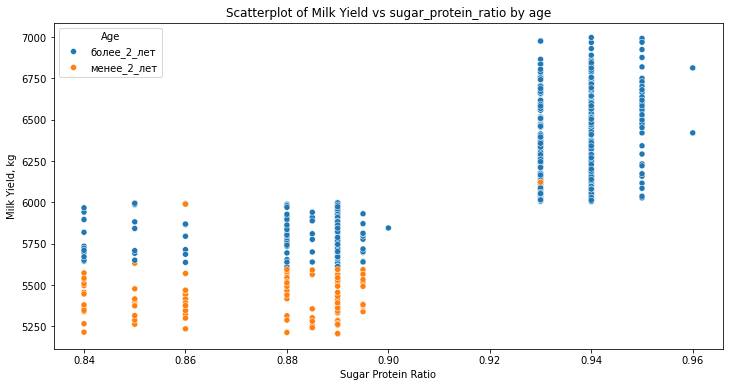

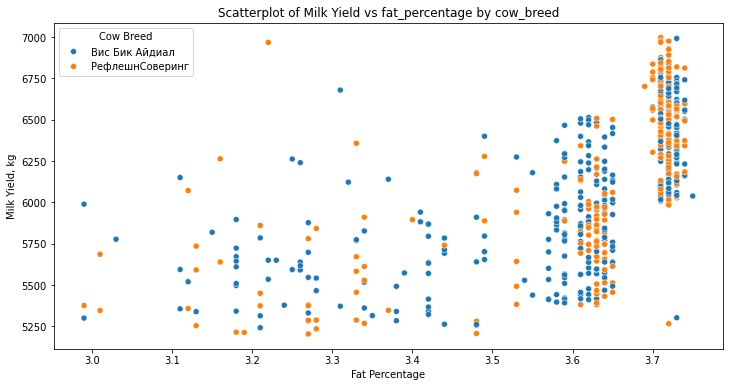

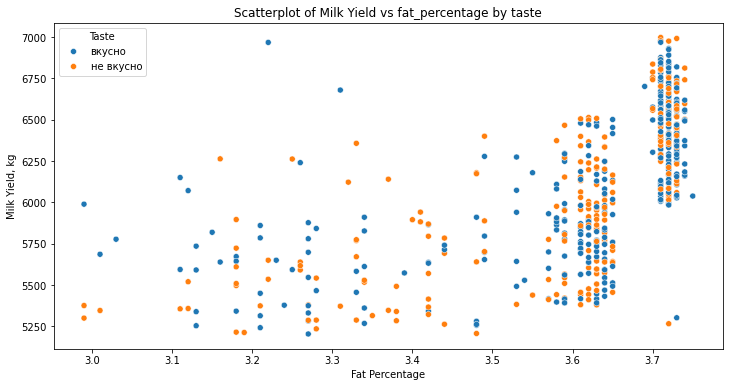

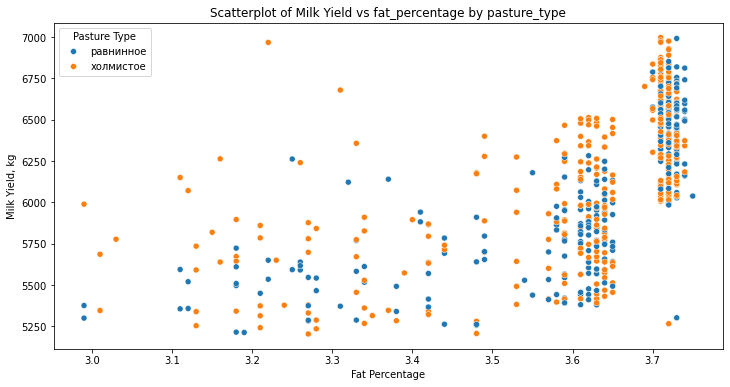

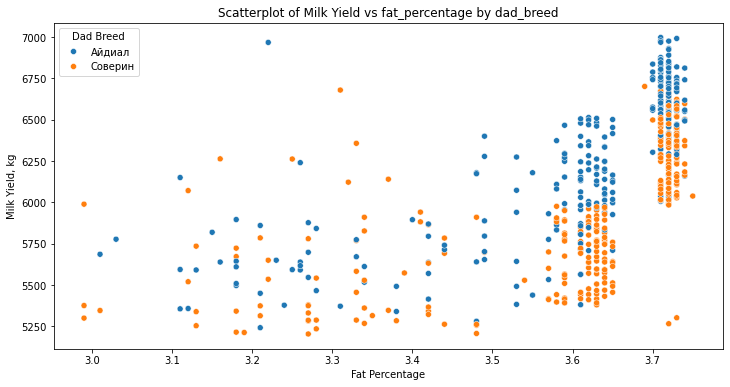

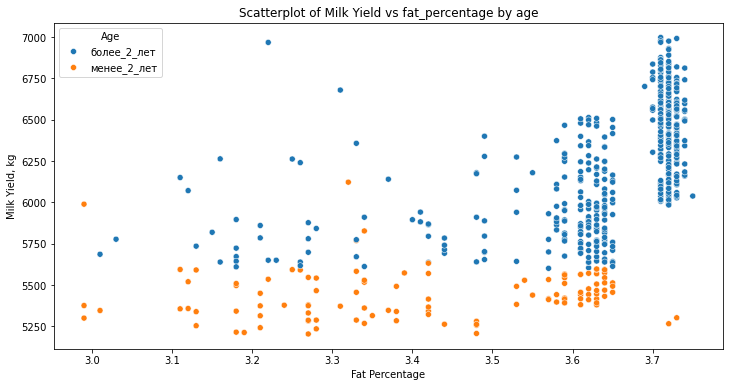

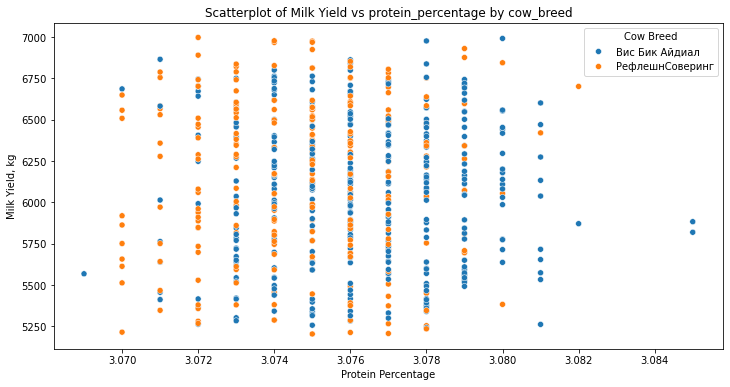

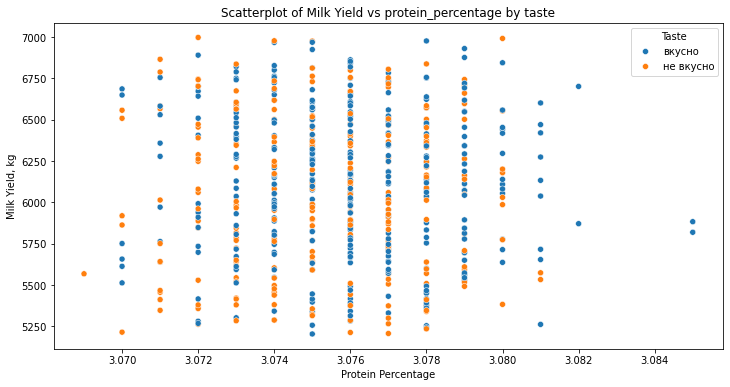

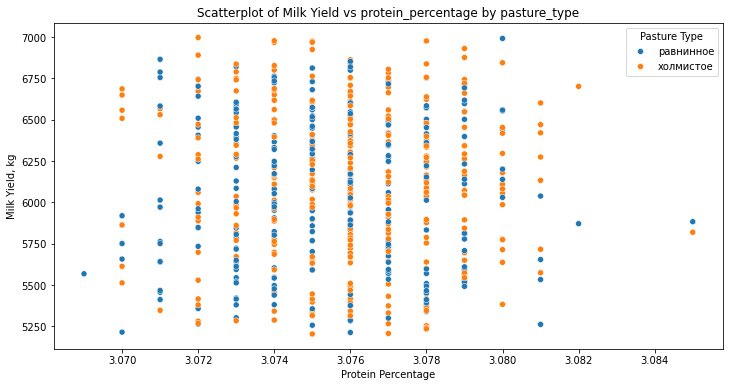

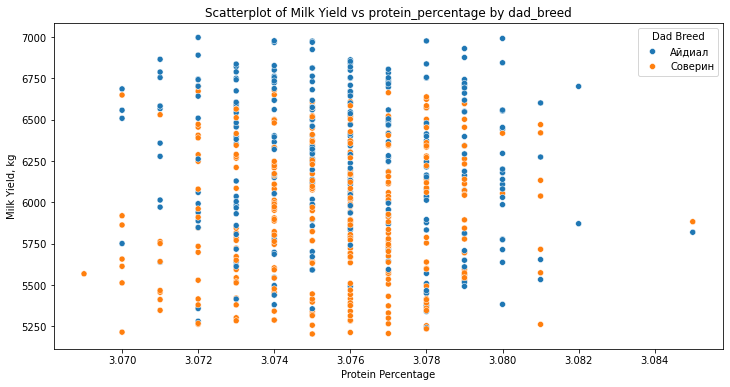

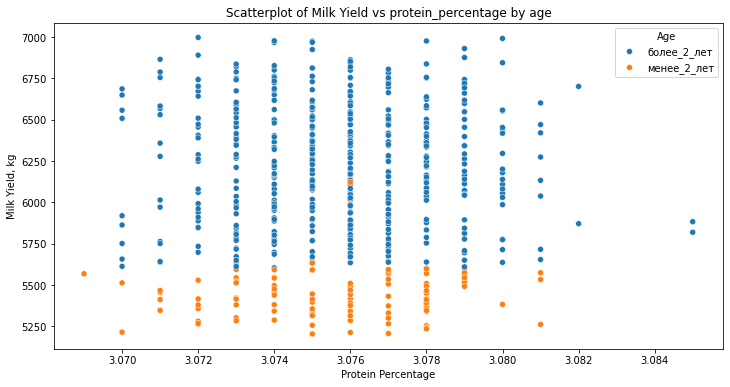

In [80]:
#напишем функцию для автоматизации построения диаграмм рассеяния 
for q_column in quantitative_columns:
    for c_column in categorical_columns:
        plt.figure(figsize= (12,6))
        sns.scatterplot(data=ferma, x=q_column, y='milk_yield_kg', hue= c_column)
        plt.title(f'Scatterplot of Milk Yield vs {q_column} by {c_column}')
        plt.xlabel(q_column.replace('_', ' ').title())
        plt.ylabel('Milk Yield, kg')
        plt.legend(title=c_column.replace('_', ' ').title())
        plt.show()

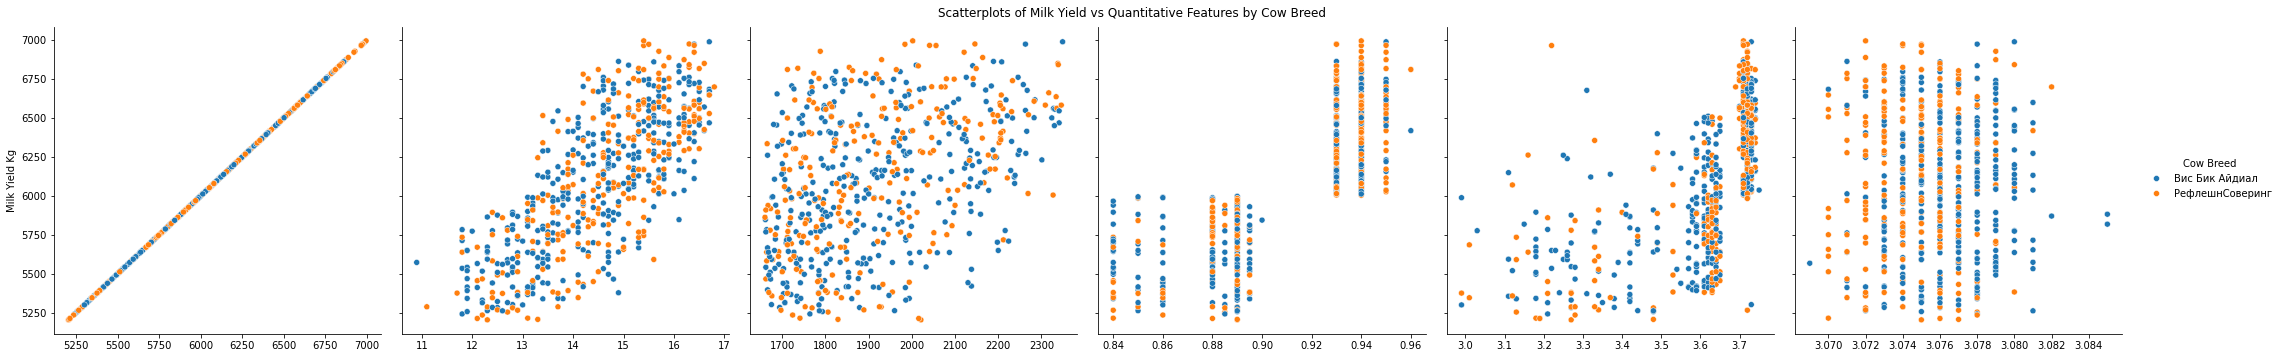

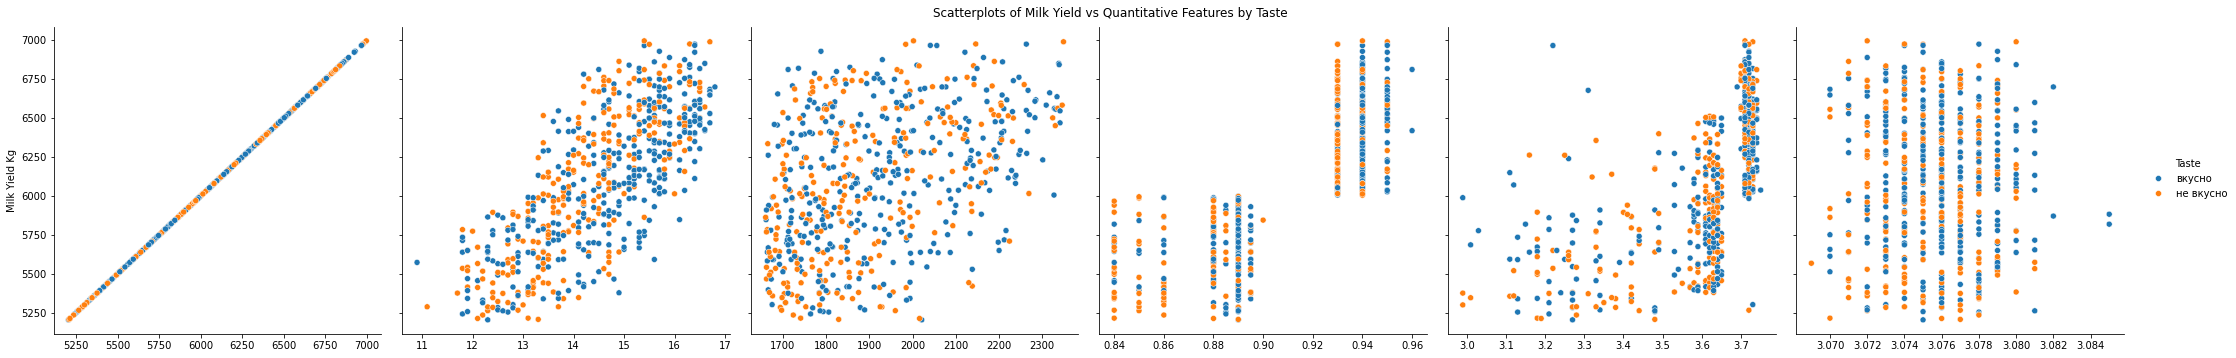

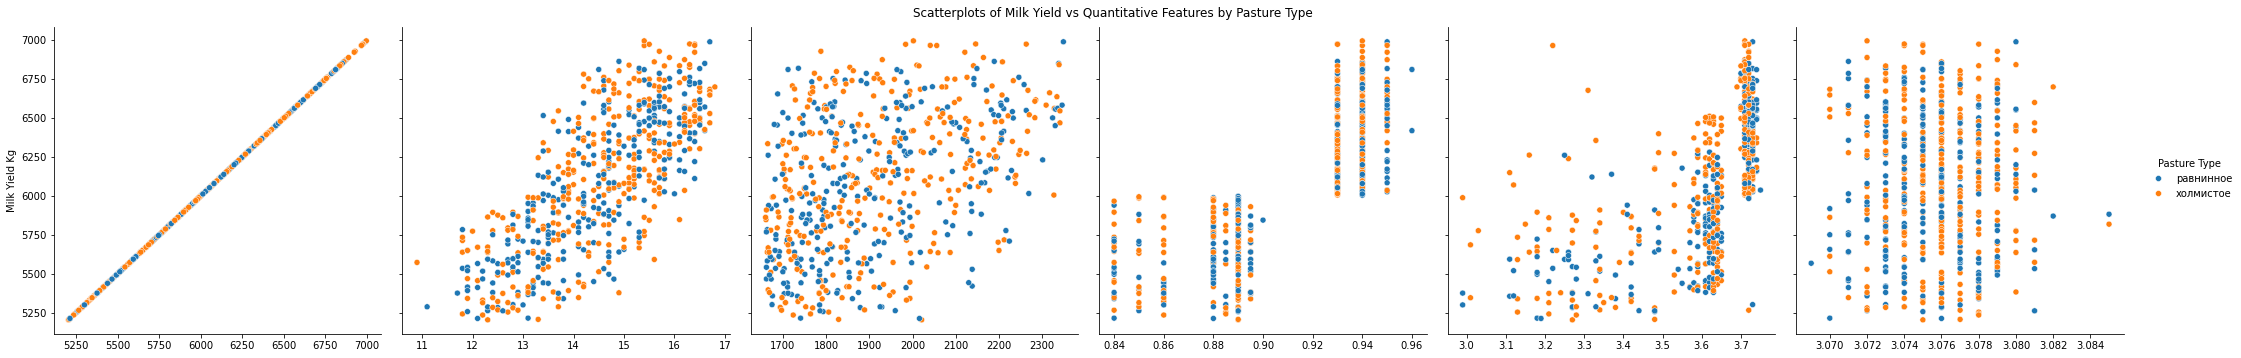

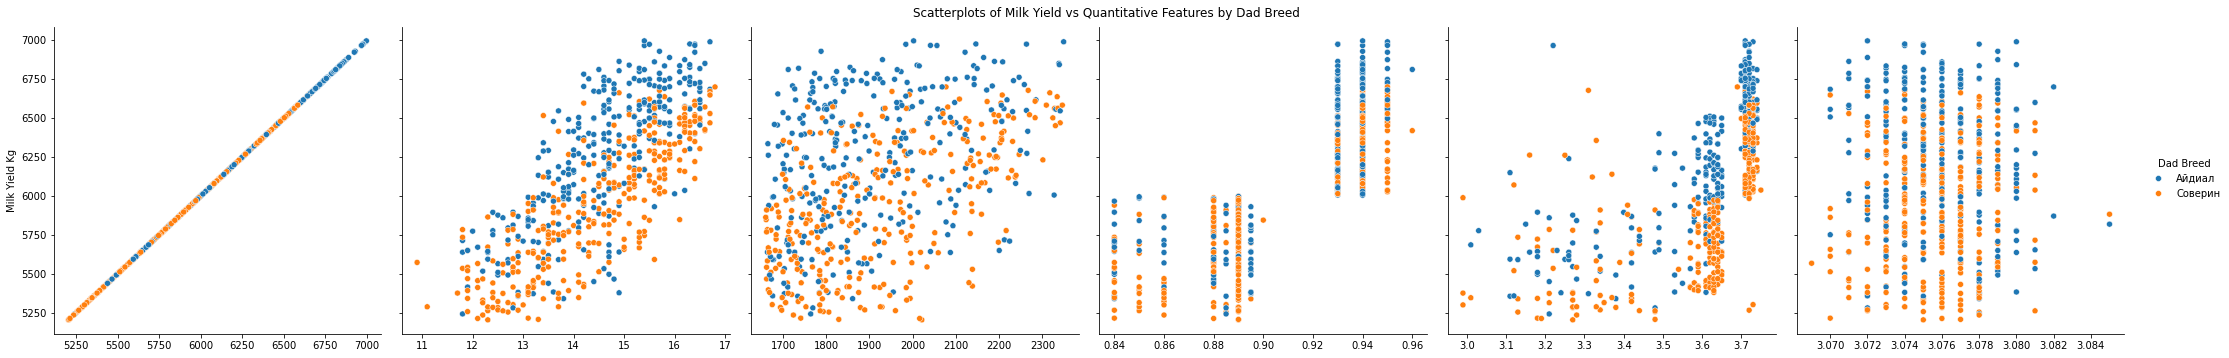

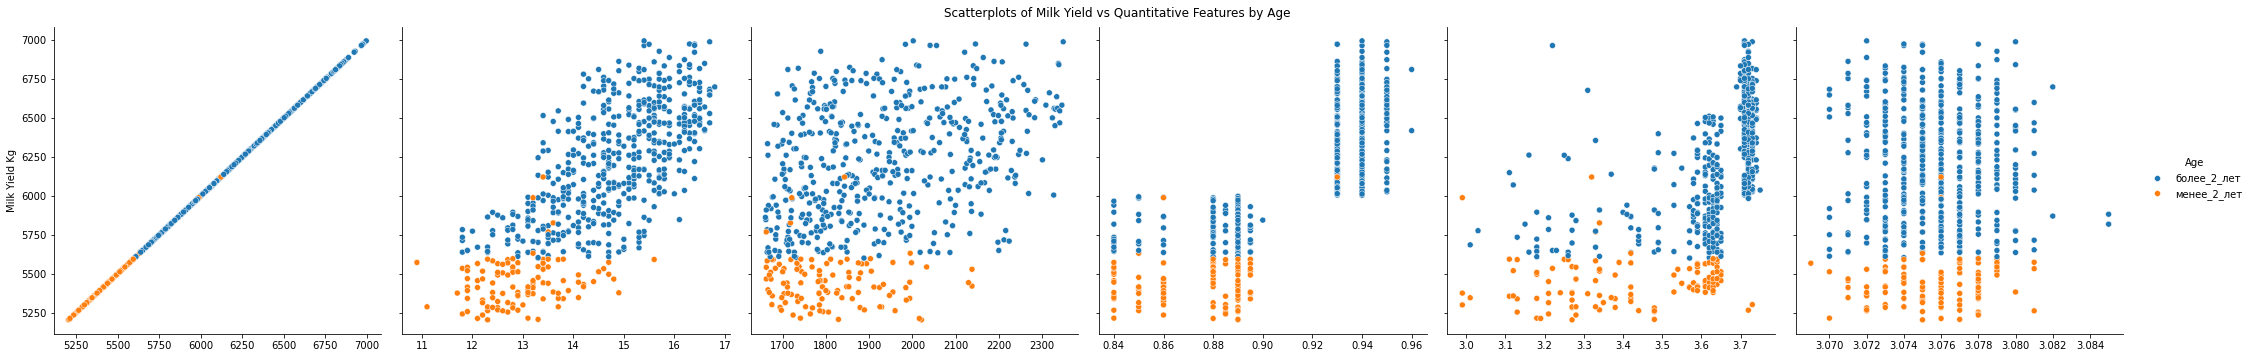

In [81]:
#укажем целевую переменную
target = 'milk_yield_kg'
# Построим диаграмму рассеяния с использованием PairGrid
for category in categorical_columns:
    g = sns.PairGrid(ferma, hue=category, x_vars=quantitative_columns, y_vars=[target], height=5)
    g.map(sns.scatterplot)
    g.add_legend(title=category.replace('_', ' ').title())
    g.set(xlabel='', ylabel=target.replace('_', ' ').title())
    g.fig.suptitle(f'Scatterplots of Milk Yield vs Quantitative Features by {category.replace("_", " ").title()}', y=1.02)
    plt.show()

Попробуем сделать вывод и ответить на несколько вопросов: 

1. Тип взаимосвязи между входными признаками

Опишем полученные зависимости:

1) Milk Yield vs Energy Feed Unit:

На графике видно, что существует положительная корреляция между удоем молока и показателем питательности корма. Это значит, что более питательный корм может способствовать увеличению удоя коров. Интересная зависимость была в отношениее категориального признака 'age'. Так, в случае с коровами в возрасте более 2-х лет мы видим высокую корреляцию в зависимости удоя молока от питательности корма. Однако, для молодых коров можно отметить низкую корреляцию между удоем молока и питательностью корма, а также у молодых коров в принципе уровень удоя молока молока ниже.

2) Milk Yield vs Crude Protein:

Наблюдается умеренная положительная корреляция, что указывает на то, что увеличение содержания сырого протеина в корме может приводить к увеличению удоя.

3) Milk Yield vs Sugar-Protein Ratio:

Видна положительная корреляция, что может свидетельствовать о том, что оптимальное соотношение сахара к протеину в корме также способствует более высокому удою.

4) Milk Yield vs Fat Percentage:

Существует положительная корреляция, что может означать, что более высокий процент жира в молоке связан с большим удоем. У коров породы Айдиал жирность молока выше, чем у породы Соверин.

5) Milk Yield vs Protein Percentage:

Корреляция слабая, что может указывать на слабую связь между содержанием белка в молоке и удоем.

2. Есть ли нелинейные связи между целевым и входными признаками? Нужно ли вводить в модель дополнительные признаки, чтобы это учесть?

Исходя из данных диаграмм рассеяния, нелинейная связь образуется между целевым признаком Milk Yield и Protein Percentage, а также между Milk Yield и sugar_protein_ratio и Milk Yield и Energy Feed Unit:

3. Наблюдается ли мультиколлинеарность между входными признаками? 

Как правило, о мультиколлинеарности говорят при значении коэффициента корреляции от 0.9 до 0.95 по модулю. Исходя из нашей корреляционной матрицы, у нас таких значений нет.

## 5. Обучение модели линейной регрессии

Попробуем обучить модель линейной регрессии

### 5.1 Обучение первой модели

Для отбора признаков, подходящих для модели линейной регрессии, следует учитывать несколько факторов: наличие линейной связи между признаками и целевым признаком, а также причинно-следственные связи, которые могут объяснять удой коров. 

- energy_feed_unit (Энергетическая кормовая единица)
Причинно-следственная связь: Энергетическая ценность корма напрямую влияет на продуктивность коровы.
Корреляция: Высокая положительная корреляция с удоем (0.714499).

- crude_protein_g (Сырой протеин, г)
Причинно-следственная связь: Содержание белка в корме важно для здоровья и продуктивности коровы.
Корреляция: Умеренная положительная корреляция с удоем (0.376764).
Решение: Включить в модель.

- sugar_protein_ratio (Сахаро-протеиновое соотношение)
Причинно-следственная связь: Баланс сахара и протеина в корме может влиять на обмен веществ коровы и, следовательно, на удой.
Корреляция: Высокая положительная корреляция с удоем (0.790841).

- fat_percentage (Жирность, %)
Причинно-следственная связь: Жирность молока может быть связана с питанием и общей продуктивностью коровы.
Корреляция: Умеренная положительная корреляция с удоем (0.648960).

- protein_percentage (Белок, %)
Причинно-следственная связь: Содержание белка в молоке может указывать на общее здоровье и продуктивность коровы.
Корреляция: Низкая положительная корреляция с удоем (0.036683).

- cow_breed (Порода)
Причинно-следственная связь: Разные породы коров могут иметь различные уровни продуктивности.
Корреляция: Категориальный признак, не включен в корреляционную матрицу.

- pasture_type (Тип пастбища)
Причинно-следственная связь: Тип пастбища может влиять на качество и количество потребляемого коровами корма.
Корреляция: Категориальный признак, не включен в корреляционную матрицу.

- dad_breed (порода папы_быка)
Причинно-следственная связь: Генетика играет важную роль в продуктивности коров.
Корреляция: Категориальный признак, не включен в корреляционную матрицу.

- taste (Вкус молока)
Причинно-следственная связь: Вкус молока может быть косвенным показателем здоровья коровы и качества корма.
Корреляция: Бинарный признак, не включен в корреляционную матрицу.

- age (Возраст)
Причинно-следственная связь: Возраст коровы влияет на ее продуктивность.
Корреляция: Бинарный признак, не включен в корреляционную матрицу.

In [82]:
#Разделим данные на признаки и целевую переменную
X= ferma.drop(['id','milk_yield_kg','taste'], axis=1)
y= ferma['milk_yield_kg']

In [83]:
#проверим. Выведем названия всех признаков в датасете, включенных в модель
X.columns

Index(['energy_feed_unit', 'crude_protein_g', 'sugar_protein_ratio',
       'cow_breed', 'pasture_type', 'dad_breed', 'fat_percentage',
       'protein_percentage', 'age'],
      dtype='object')

In [84]:
#выведем первые значения целевой переменной
y.head()

0    5863
1    5529
2    5810
3    5895
4    5302
Name: milk_yield_kg, dtype: int64

In [85]:
#Разделим модель на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [86]:
#выделим числовые и категориальные признаки
cat_col_names = ['cow_breed', 'pasture_type', 'dad_breed', 'age']
num_col_names = ['energy_feed_unit', 'crude_protein_g', 'sugar_protein_ratio', 'fat_percentage','protein_percentage']

Далее приступим к подготовке признаков (к масштабированию и кодированию)

In [87]:
#кодирование категориальных признаков
encoder = OneHotEncoder(drop='first', sparse_output = False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

In [88]:
encoder_col_names = encoder.get_feature_names_out(cat_col_names)

In [89]:
#приступим к масштабированию количественных признаков с помощью StandardScaler()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

In [90]:
#создадим тренировочные и тестовые датафреймы из закодированных и отмасштабированных данных
X_train_ohe = pd.DataFrame(X_train_ohe, columns = encoder_col_names)
X_test_ohe  = pd.DataFrame(X_test_ohe, columns = encoder_col_names)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = num_col_names)

In [91]:
#объединим два набора данных (признаков) по горизонтали, создавая полный набор признаков для обучения и тестирования модели
X_train = pd.concat([X_train_ohe, X_train_scaled], axis = 1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis = 1)

In [92]:
#обучим модель и получим предсказания на тестовых данных
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
predictions = model_lr.predict(X_test)

In [93]:
# оценим качество модели, используя метрику R2
r2_score = r2_score(y_test, predictions)

In [94]:
r2_score

0.8362061448121225

R2 выглядит неплохо для данной модели (модель хорошо себя показывает в 84% случаев), но есть к чему стремится что б ее улучшить

In [95]:
#Проведем анализ остатков 
residuals = y_test - predictions

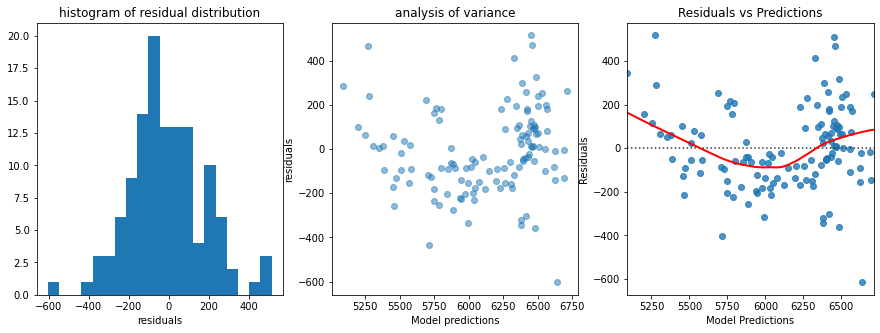

In [96]:
#Построим графики по количественным признакам - гистограмму частотности
#распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows = 1, ncols= 3, figsize = (15, 5))

axes[0].hist(residuals, bins = 20)
axes[0].set_title('histogram of residual distribution')
axes[0].set_xlabel('residuals')

axes[1].scatter(predictions, residuals, alpha = 0.5)
axes[1].set_xlabel('Model predictions')
axes[1].set_ylabel('residuals')
axes[1].set_title('analysis of variance')

# sns.residplot для оценки распределения остатков и их гомоскедастичности
sns.residplot(x=predictions, y=residuals, lowess=True, ax=axes[2], line_kws={'color': 'red', 'lw': 2})
axes[2].set_title('Residuals vs Predictions')
axes[2].set_xlabel('Model Predictions')
axes[2].set_ylabel('Residuals')

plt.show()

Остатки модели не только показывают разницу между предсказанным и истинным значениями. Они также отражают закономерности, которые позволяют судить о качестве модели. Анализ остатков проверяет не решения модели, а то, насколько хорошо она замечает взаимосвязи между признаками. Если она не справляется с этим, то уже не важно, близки ли её предсказания к исходным значениям. Модель будет работать нестабильно. 

1. Если посмотрим на график распределения остатков (график слева), то он выгядит чуть смещенным влево относительно 0
2. Если посмотрим на диаграмму рассеяния (график справа) остатков в зависимости от прогнозных значений модели, то отметим, что диаграмма принимает форму дуги: нелинейно распределённые остатки. Поскольку у остатков нарушается свойство постоянства дисперсии, то модель в работе использовать нежелательно, её нужно улучшить.

Чтобы улучшить модель можно пойти 2-мя путями:
1. Трансформировать данные, чтобы изменить взаимосвязь входных признаков с целевым. 
2. Найти и добавить в модель дополнительные признаки. Скорее всего, на этапе сбора данных не учли какие-то признаки.

### 5.2 Обучение второй линейной модели

Попробуем улучшить модель полученную на первом этапе и начнем с первого метода (трансформирование данных, чтобы изменить взаимосвязь входных признаков с целевым). Для этого, еще раз посмотрим на диаграммы рассеяния признаков относительно целевой переменной, на них можно увидеть, что некоторые входные признаки связаны с целевым нелинейно.

Мы обнаружили, что СПО и Удой связаны нелинейно. На их диаграмме рассеяния наблюдения сгруппированы в два кластера, причём есть такое значение СПО (примерно 0.91), которое можно считать границей между кластерами. 
Чтобы устранить нелинейность, преобразуем СПО в категориальный бинарный признак, использовав эту границу.

In [97]:
ferma_copy = ferma.copy()

In [98]:
#выведем первые 20 строк датасета ферма
ferma_copy.head(20)

id  milk_yield_kg  energy_feed_unit  crude_protein_g  sugar_protein_ratio  \
0    1           5863              14.2             1743                0.890   
1    2           5529              12.8             2138                0.890   
2    3           5810              14.0             1854                0.885   
3    4           5895              12.4             2012                0.885   
4    5           5302              12.8             1675                0.885   
5    6           5254              12.7             1806                0.885   
6    7           5910              13.2             1792                0.885   
7    8           6179              14.7             1806                0.930   
8    9           6783              14.2             1918                0.940   
9   10           5339              13.4             1791                0.895   
10  11           5591              13.7             1678                0.895   
11  12           6563              16.5             2328                0.930   
12  13           6173              15.4             2193                0.930   
13  14           6131              14.5             1766                0.930   
14  15           6014              16.0             1769                0.930   
15  16           6518              15.6             1747                0.930   
17  18           5777              12.4             1873                0.895   
18  19           6461              15.7             2159                0.930   
19  20           5698              14.3             1759                0.895   
20  21           6752              15.5             1924                0.930   

          cow_breed pasture_type dad_breed  fat_percentage  \
0    Вис Бик Айдиал    равнинное    Айдиал            3.58   
1    Вис Бик Айдиал    равнинное   Соверин            3.54   
2   РефлешнСоверинг    холмистое   Соверин            3.59   
3   РефлешнСоверинг    холмистое    Айдиал            3.40   
4    Вис Бик Айдиал    равнинное   Соверин            3.73   
5   РефлешнСоверинг    холмистое   Соверин            3.13   
6    Вис Бик Айдиал    равнинное   Соверин            3.48   
7    Вис Бик Айдиал    равнинное    Айдиал            3.55   
8   РефлешнСоверинг    холмистое    Айдиал            3.71   
9    Вис Бик Айдиал    холмистое   Соверин            3.13   
10  РефлешнСоверинг    холмистое    Айдиал            3.13   
11   Вис Бик Айдиал    холмистое   Соверин            3.71   
12  РефлешнСоверинг    холмистое   Соверин            3.72   
13  РефлешнСоверинг    равнинное    Айдиал            3.61   
14   Вис Бик Айдиал    равнинное    Айдиал            3.71   
15   Вис Бик Айдиал    равнинное    Айдиал            3.73   
17   Вис Бик Айдиал    холмистое    Айдиал            3.03   
18  РефлешнСоверинг    холмистое   Соверин            3.72   
19  РефлешнСоверинг    холмистое   Соверин            3.49   
20  РефлешнСоверинг    холмистое    Айдиал            3.73   

    protein_percentage      taste          age  
0                3.076     вкусно  более_2_лет  
1                3.079     вкусно  менее_2_лет  
2                3.074  не вкусно  более_2_лет  
3                3.075  не вкусно  более_2_лет  
4                3.073     вкусно  менее_2_лет  
5                3.078     вкусно  менее_2_лет  
6                3.077     вкусно  более_2_лет  
7                3.076     вкусно  более_2_лет  
8                3.077     вкусно  более_2_лет  
9                3.075     вкусно  менее_2_лет  
10               3.075     вкусно  менее_2_лет  
11               3.075     вкусно  более_2_лет  
12               3.075     вкусно  более_2_лет  
13               3.076  не вкусно  более_2_лет  
14               3.071  не вкусно  более_2_лет  
15               3.076     вкусно  более_2_лет  
17               3.080     вкусно  более_2_лет  
18               3.073  не вкусно  более_2_лет  
19               3.072     вкусно  более_2_лет  
20               3.

In [99]:
#преобразуем СПО в категориальный бинарный признак, использовав значение 0.91 как границу
ferma_copy['sugar_protein_ratio'] = (ferma_copy['sugar_protein_ratio']> 0.91).astype(int)

In [100]:
#выведем первые 20 строк датасета ferma
ferma_copy.head(20)

id  milk_yield_kg  energy_feed_unit  crude_protein_g  sugar_protein_ratio  \
0    1           5863              14.2             1743                    0   
1    2           5529              12.8             2138                    0   
2    3           5810              14.0             1854                    0   
3    4           5895              12.4             2012                    0   
4    5           5302              12.8             1675                    0   
5    6           5254              12.7             1806                    0   
6    7           5910              13.2             1792                    0   
7    8           6179              14.7             1806                    1   
8    9           6783              14.2             1918                    1   
9   10           5339              13.4             1791                    0   
10  11           5591              13.7             1678                    0   
11  12           6563              16.5             2328                    1   
12  13           6173              15.4             2193                    1   
13  14           6131              14.5             1766                    1   
14  15           6014              16.0             1769                    1   
15  16           6518              15.6             1747                    1   
17  18           5777              12.4             1873                    0   
18  19           6461              15.7             2159                    1   
19  20           5698              14.3             1759                    0   
20  21           6752              15.5             1924                    1   

          cow_breed pasture_type dad_breed  fat_percentage  \
0    Вис Бик Айдиал    равнинное    Айдиал            3.58   
1    Вис Бик Айдиал    равнинное   Соверин            3.54   
2   РефлешнСоверинг    холмистое   Соверин            3.59   
3   РефлешнСоверинг    холмистое    Айдиал            3.40   
4    Вис Бик Айдиал    равнинное   Соверин            3.73   
5   РефлешнСоверинг    холмистое   Соверин            3.13   
6    Вис Бик Айдиал    равнинное   Соверин            3.48   
7    Вис Бик Айдиал    равнинное    Айдиал            3.55   
8   РефлешнСоверинг    холмистое    Айдиал            3.71   
9    Вис Бик Айдиал    холмистое   Соверин            3.13   
10  РефлешнСоверинг    холмистое    Айдиал            3.13   
11   Вис Бик Айдиал    холмистое   Соверин            3.71   
12  РефлешнСоверинг    холмистое   Соверин            3.72   
13  РефлешнСоверинг    равнинное    Айдиал            3.61   
14   Вис Бик Айдиал    равнинное    Айдиал            3.71   
15   Вис Бик Айдиал    равнинное    Айдиал            3.73   
17   Вис Бик Айдиал    холмистое    Айдиал            3.03   
18  РефлешнСоверинг    холмистое   Соверин            3.72   
19  РефлешнСоверинг    холмистое   Соверин            3.49   
20  РефлешнСоверинг    холмистое    Айдиал            3.73   

    protein_percentage      taste          age  
0                3.076     вкусно  более_2_лет  
1                3.079     вкусно  менее_2_лет  
2                3.074  не вкусно  более_2_лет  
3                3.075  не вкусно  более_2_лет  
4                3.073     вкусно  менее_2_лет  
5                3.078     вкусно  менее_2_лет  
6                3.077     вкусно  более_2_лет  
7                3.076     вкусно  более_2_лет  
8                3.077     вкусно  более_2_лет  
9                3.075     вкусно  менее_2_лет  
10               3.075     вкусно  менее_2_лет  
11               3.075     вкусно  более_2_лет  
12               3.075     вкусно  более_2_лет  
13               3.076  не вкусно  более_2_лет  
14               3.071  не вкусно  более_2_лет  
15               3.076     вкусно  более_2_лет  
17               3.080     вкусно  более_2_лет  
18               3.073  не вкусно  более_2_лет  
19               3.072     вкусно  более_2_лет  
20               3.

Так в результате данные по СПО разделили на два класстера: 0- это первый кластер со значениями <= 0.91, 1- это второй кластер со значениями > 0.91. Можно убедиться, сравнив данные до преобразования и после.

Также было обнаружено, что ЭКЕ и Удой также связаны нелинейно. Нелинейность между ними можно исключить, если ввести новый признак ЭКЕ в квадрате. Сделаем это

In [101]:
#создадим новый признак energy_feed_unit_squared
ferma_copy['energy_feed_unit_squared'] = ferma_copy['energy_feed_unit'] ** 2

Теперь попробуем повторить создать вторую модель линейной регрессии с уже обновленными признаками

In [102]:
#Разделим данные на признаки и целевую переменную
X2= ferma_copy.drop(['id','milk_yield_kg','energy_feed_unit','taste'], axis=1)
y2= ferma_copy['milk_yield_kg']

тут мы убрали 'energy_feed_unit' что бы исключить мультиколлинеарность с 'energy_feed_unit_squared'

In [103]:
#проверим. Выведем названия всех признаков в датасете, включенных в модель
X2.columns

Index(['crude_protein_g', 'sugar_protein_ratio', 'cow_breed', 'pasture_type',
       'dad_breed', 'fat_percentage', 'protein_percentage', 'age',
       'energy_feed_unit_squared'],
      dtype='object')

In [104]:
#выведем первые значения целевой переменной
y.head()

0    5863
1    5529
2    5810
3    5895
4    5302
Name: milk_yield_kg, dtype: int64

In [105]:
#Разделим модель на обучающую и тестовую выборки
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state = 42)

In [106]:
#выделим числовые и категориальные признаки
cat_col_names2 = ['cow_breed', 'pasture_type', 'dad_breed', 'age', 'sugar_protein_ratio']
num_col_names2 = ['energy_feed_unit_squared', 'crude_protein_g', 'fat_percentage', 'protein_percentage']

Далее приступим к подготовке признаков (к масштабированию и кодированию)

In [107]:
#кодирование категориальных признаков
encoder2 = OneHotEncoder(drop='first', sparse_output = False)
X2_train_ohe = encoder2.fit_transform(X2_train[cat_col_names2])
X2_test_ohe = encoder2.transform(X2_test[cat_col_names2])

In [108]:
encoder_col_names2 = encoder2.get_feature_names_out(cat_col_names2)

In [109]:
#приступим к масштабированию количественных признаков с помощью StandardScaler()
scaler2 = StandardScaler()
X2_train_scaled = scaler2.fit_transform(X2_train[num_col_names2])
X2_test_scaled = scaler2.transform(X2_test[num_col_names2])

In [110]:
#создадим тренировочные и тестовые датафреймы из закодированных и отмасштабированных данных
X2_train_ohe = pd.DataFrame(X2_train_ohe, columns = encoder_col_names2)
X2_test_ohe  = pd.DataFrame(X2_test_ohe, columns = encoder_col_names2)
X2_train_scaled = pd.DataFrame(X2_train_scaled, columns = num_col_names2)
X2_test_scaled = pd.DataFrame(X2_test_scaled, columns = num_col_names2)

In [111]:
#объединим два набора данных (признаков) по горизонтали, создавая полный набор признаков для обучения и тестирования модели
X2_train = pd.concat([X2_train_ohe, X2_train_scaled], axis = 1)
X2_test = pd.concat([X2_test_ohe, X2_test_scaled], axis = 1)

In [112]:
#обучим модель и получим предсказания на тестовых данных
model_lr2 = LinearRegression()
model_lr2.fit(X2_train, y2_train)
predictions2 = model_lr2.predict(X2_test)

In [113]:
# оценим качество модели, используя метрику R2
r2_score2 =  sklearn_r2_score(y2_test, predictions2)

In [114]:
r2_score2

0.8596535102733123

Модель хорошо себя показывает в 86% случаев. Улучшили модель всего на 0.02%

In [115]:
#Проведем анализ остатков 
residuals2 = y2_test - predictions2

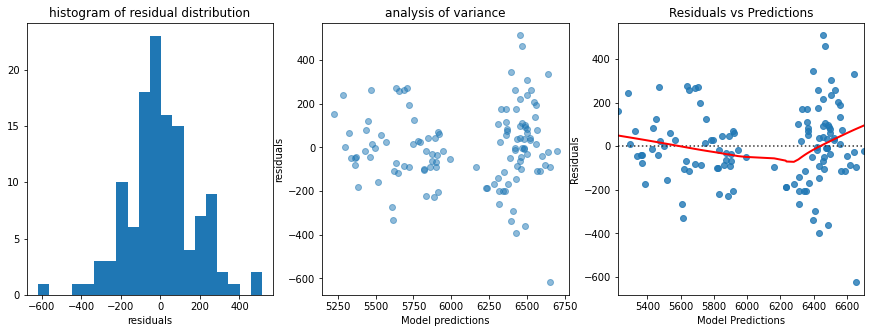

In [116]:
#Построим графики по количественным признакам - гистограмму частотности
#распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows = 1, ncols= 3, figsize = (15,5))

axes[0].hist(residuals2, bins = 20)
axes[0].set_title('histogram of residual distribution')
axes[0].set_xlabel('residuals')

axes[1].scatter(predictions2, residuals2, alpha = 0.5)
axes[1].set_xlabel('Model predictions')
axes[1].set_ylabel('residuals')
axes[1].set_title('analysis of variance')

# sns.residplot для оценки распределения остатков и их гомоскедастичности
sns.residplot(x=predictions2, y=residuals2, lowess=True, ax=axes[2], line_kws={'color': 'red', 'lw': 2})
axes[2].set_title('Residuals vs Predictions')
axes[2].set_xlabel('Model Predictions')
axes[2].set_ylabel('Residuals')

plt.show()

1) Если посмотрим на график распределения остатков (график слева), то он выглядит нормальным.

2) Если посмотрим на диаграмму рассеяния (график справа) остатков в зависимости от прогнозных значений модели, то отметим, что диаграмма принимает все также форму дуги: нелинейно распределённые остатки. Поскольку у остатков нарушается свойство постоянства дисперсии, то модель в работе использовать нежелательно, её нужно улучшить.

### 5.3 Обучение третьей линейной модели

Теперь попробуем использовать второй подход для улучшения данных - найдем и добавим в модель дополнительные признаки. 

Добавим признак Имя Папы (dad_name) из файла ferma_dad.csv, соединив его с остальными данными ferma_main.csv по ключу.

In [117]:
#посмотрим на информацию о датафрейме ferma
ferma.info()

<class 'pandas.core.frame.DataFrame'>
Index: 608 entries, 0 to 628
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   608 non-null    int64  
 1   milk_yield_kg        608 non-null    int64  
 2   energy_feed_unit     608 non-null    float64
 3   crude_protein_g      608 non-null    int64  
 4   sugar_protein_ratio  608 non-null    float64
 5   cow_breed            608 non-null    object 
 6   pasture_type         608 non-null    object 
 7   dad_breed            608 non-null    object 
 8   fat_percentage       608 non-null    float64
 9   protein_percentage   608 non-null    float64
 10  taste                608 non-null    object 
 11  age                  608 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 61.8+ KB


In [118]:
#объединим 2 таблицы по ключу id
merged_ferma = pd.merge(ferma, ferma_dad, on='id', how='left')

In [119]:
#посмотрим на общую информацию объединенной таблицы
merged_ferma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   608 non-null    int64  
 1   milk_yield_kg        608 non-null    int64  
 2   energy_feed_unit     608 non-null    float64
 3   crude_protein_g      608 non-null    int64  
 4   sugar_protein_ratio  608 non-null    float64
 5   cow_breed            608 non-null    object 
 6   pasture_type         608 non-null    object 
 7   dad_breed            608 non-null    object 
 8   fat_percentage       608 non-null    float64
 9   protein_percentage   608 non-null    float64
 10  taste                608 non-null    object 
 11  age                  608 non-null    object 
 12  dad_name             608 non-null    object 
dtypes: float64(4), int64(3), object(6)
memory usage: 61.9+ KB


Для устранения нелинейности повторим шаги, сделанные в прошлой модели

In [120]:
#преобразуем СПО в категориальный бинарный признак, использовав значение 0.91 как границу
merged_ferma['sugar_protein_ratio'] = (merged_ferma['sugar_protein_ratio']> 0.91).astype(int)

In [121]:
#создадим новый признак energy_feed_unit_squared 
merged_ferma['energy_feed_unit_squared'] = merged_ferma['energy_feed_unit'] ** 2

In [122]:
#Разделим данные на признаки и целевую переменную
X3= merged_ferma.drop(['id','milk_yield_kg','energy_feed_unit','taste'], axis=1)
y3= merged_ferma['milk_yield_kg']

In [123]:
#проверим. Выведем названия всех признаков в датасете, включенных в модель
X3.columns

Index(['crude_protein_g', 'sugar_protein_ratio', 'cow_breed', 'pasture_type',
       'dad_breed', 'fat_percentage', 'protein_percentage', 'age', 'dad_name',
       'energy_feed_unit_squared'],
      dtype='object')

In [124]:
#Разделим модель на обучающую и тестовую выборки
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.2, random_state = 42)

In [125]:
#выделим числовые и категориальные признаки
cat_col_names3 = ['cow_breed', 'pasture_type', 'dad_breed', 'age', 'sugar_protein_ratio', 'dad_name']
num_col_names3 = ['energy_feed_unit_squared', 'crude_protein_g', 'fat_percentage', 'protein_percentage']

Далее приступим к подготовке признаков (к масштабированию и кодированию

In [126]:
#кодирование категориальных признаков
encoder3 = OneHotEncoder(drop='first', sparse_output = False)
X3_train_ohe = encoder3.fit_transform(X3_train[cat_col_names3])
X3_test_ohe = encoder3.transform(X3_test[cat_col_names3])

In [127]:
encoder_col_names3 = encoder3.get_feature_names_out(cat_col_names3)

In [128]:
encoder_col_names3

array(['cow_breed_РефлешнСоверинг', 'pasture_type_холмистое',
       'dad_breed_Соверин', 'age_менее_2_лет', 'sugar_protein_ratio_1',
       'dad_name_Буйный', 'dad_name_Геркулес', 'dad_name_Соловчик'],
      dtype=object)

In [129]:
#приступим к масштабированию количественных признаков с помощью StandardScaler()
scaler3 = StandardScaler()
X3_train_scaled = scaler3.fit_transform(X3_train[num_col_names3])
X3_test_scaled = scaler3.transform(X3_test[num_col_names3])

In [130]:
#создадим тренировочные и тестовые датафреймы из закодированных и отмасштабированных данных
X3_train_ohe = pd.DataFrame(X3_train_ohe, columns = encoder_col_names3)
X3_test_ohe  = pd.DataFrame(X3_test_ohe, columns = encoder_col_names3)
X3_train_scaled = pd.DataFrame(X3_train_scaled, columns = num_col_names3)
X3_test_scaled = pd.DataFrame(X3_test_scaled, columns = num_col_names3)

In [131]:
#объединим два набора данных (признаков) по горизонтали, создавая полный набор признаков для обучения и тестирования модели
X3_train = pd.concat([X3_train_ohe, X3_train_scaled], axis = 1)
X3_test = pd.concat([X3_test_ohe, X3_test_scaled], axis = 1)

In [132]:
#обучим модель и получим предсказания на тестовых данных
model_lr3 = LinearRegression()
model_lr3.fit(X3_train, y3_train)
predictions3 = model_lr3.predict(X3_test)

In [133]:
# оценим качество модели, используя метрику R2
r2_score3 =  sklearn_r2_score(y3_test, predictions3)

In [134]:
r2_score3

0.8620281851825173

Улучшили всего на 0.03%

In [135]:
#Проведем анализ остатков 
residuals3 = y3_test - predictions3

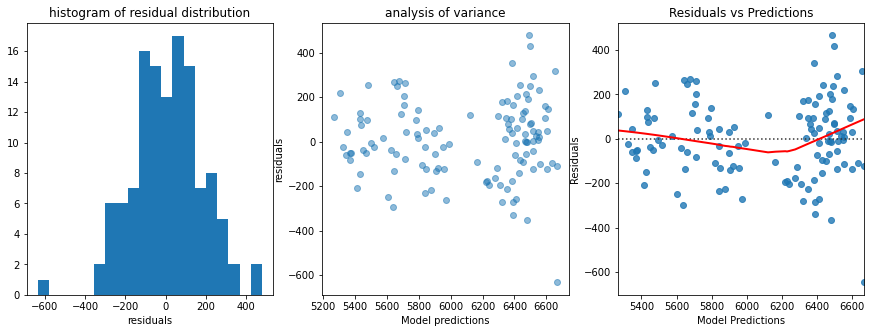

In [136]:
#Построим графики по количественным признакам - гистограмму частотности
#распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows = 1, ncols= 3, figsize = (15,5))

axes[0].hist(residuals3, bins = 20)
axes[0].set_title('histogram of residual distribution')
axes[0].set_xlabel('residuals')

axes[1].scatter(predictions3, residuals3, alpha = 0.5)
axes[1].set_xlabel('Model predictions')
axes[1].set_ylabel('residuals')
axes[1].set_title('analysis of variance')

# sns.residplot для оценки распределения остатков и их гомоскедастичности
sns.residplot(x=predictions3, y=residuals3, lowess=True, ax=axes[2], line_kws={'color': 'red', 'lw': 2})
axes[2].set_title('Residuals vs Predictions')
axes[2].set_xlabel('Model Predictions')
axes[2].set_ylabel('Residuals')

plt.show()

Новая модель не улучшила подход второй модели

In [137]:
# Оценим важности признаков с помощью коэффициентов модели
feature_importances = pd.Series(model_lr3.coef_, index=X3_train.columns).sort_values(ascending=False)

In [138]:
#выведем значения важности признаков
print("Feature Importances (Linear Regression):")
print(feature_importances)

Feature Importances (Linear Regression):
sugar_protein_ratio_1        389.293333
dad_name_Геркулес            289.931410
dad_name_Буйный              241.559850
energy_feed_unit_squared     108.060123
crude_protein_g               38.777315
pasture_type_холмистое        35.920387
dad_name_Соловчик             34.553727
dad_breed_Соверин             34.210225
fat_percentage                29.773629
cow_breed_РефлешнСоверинг     19.596060
protein_percentage           -25.426152
age_менее_2_лет             -215.643724
dtype: float64


Результаты оценки важности признаков для модели линейной регрессии показывают, что sugar_protein_ratio_1 и dad_name_Геркулес имеют наибольшее положительное влияние на прогнозируемый результат, в то время как age_менее_2_лет оказывает наибольшее отрицательное влияние. Значения важности варьируются от значительных положительных, таких как sugar_protein_ratio_1 (389.29), до заметных отрицательных, таких как age_менее_2_лет (-215.64). Это указывает на то, что признаки, связанные с сахарно-белковым отношением и определенными типами родителей, играют ключевую роль в модели, тогда как возраст менее двух лет имеет значительное негативное влияние.

In [139]:
#используем SHAP для оценки важности признаков
explainer = shap.Explainer(model_lr3, X3_train)
shap_values = explainer(X3_test)

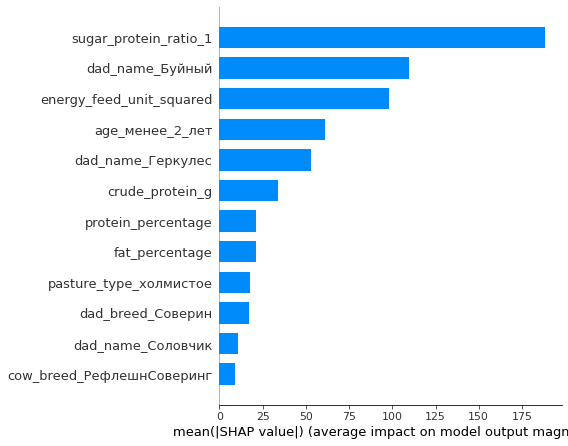

In [140]:
# построим график SHAP
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X3_test, plot_type="bar")
plt.show()

In [141]:
# напишем функцию для расчёта метрик
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mse, mae, rmse

#оценим качество моделей
metrics1 = calculate_metrics(y_test, predictions)
metrics2 = calculate_metrics(y2_test, predictions2)
metrics3 = calculate_metrics(y3_test, predictions3)

#выведем все наши метрики на экран
print(f"Model 1 - R2: {r2_score}, MSE: {metrics1[0]}, MAE: {metrics1[1]}, RMSE: {metrics1[2]}")
print(f"Model 2 - R2: {r2_score2}, MSE: {metrics2[0]}, MAE: {metrics2[1]}, RMSE: {metrics2[2]}")
print(f"Model 3 - R2: {r2_score3}, MSE: {metrics3[0]}, MAE: {metrics3[1]}, RMSE: {metrics3[2]}")

Model 1 - R2: 0.8362061448121225, MSE: 35225.56385316644, MAE: 147.479628395743, RMSE: 187.68474592562507
Model 2 - R2: 0.8596535102733123, MSE: 30182.96522640918, MAE: 130.78740493492373, RMSE: 173.73245300291242
Model 3 - R2: 0.8620281851825173, MSE: 29672.266808884506, MAE: 134.28077342518958, RMSE: 172.25639845557117


Модель 3 показала лучшие результаты среди всех трех моделей. Она имеет самый высокий коэффициент детерминации (R2 = 0.862), что означает лучшую объясняющую способность модели. Также у нее наименьшая среднеквадратичная ошибка (MSE = 29672.27) и корень из среднеквадратичной ошибки (RMSE = 172.26), что указывает на более точные прогнозы.
Модель 2 также показала хорошие результаты с высоким коэффициентом детерминации (R2 = 0.860) и низкими значениями MSE (30182.97) и RMSE (173.73). Она имеет наименьшую среднюю абсолютную ошибку (MAE = 130.79), что говорит о том, что в среднем ошибки ее предсказаний меньше.
Модель 1 продемонстрировала наименее точные результаты по сравнению с другими моделями. Ее коэффициент детерминации (R2 = 0.836) самый низкий, а значения MSE (35225.56) и RMSE (187.68) самые высокие, что указывает на более значительные отклонения в прогнозах.

Вывод:

Таким образом, Модель 3 является наилучшей по общим показателям точности, но Модель 2 демонстрирует наиболее низкие средние абсолютные ошибки. Выбор между этими моделями может зависеть от приоритетов, таких как общая точность (R2) или минимизация средней абсолютной ошибки (MAE).

In [142]:
# Рассчитаем доверительный интервал прогноза
residuals_best = y3_train - model_lr3.predict(X3_train)
confidence_interval = np.percentile(residuals_best, [2.5, 97.5])

In [143]:
confidence_interval

array([-319.35070093,  325.91510421])

Рассчитанный доверительный интервал прогноза для лучшей модели составляет от -319.35 до 325.92. Это означает следующее:
Нижняя граница доверительного интервала составляет -319.35. Это показывает, что с 95% вероятностью ошибка предсказания модели может быть не хуже, чем -319.35 (модель может недооценить значение целевой переменной не более чем на 319.35 единиц).
Верхняя граница доверительного интервала составляет 325.92. Это показывает, что с 95% вероятностью ошибка предсказания модели может быть не хуже, чем 325.92 (модель может переоценить значение целевой переменной не более чем на 325.92 единиц).
Таким образом, доверительный интервал прогноза предоставляет диапазон, в котором с высокой вероятностью будут находиться ошибки предсказаний модели, что помогает оценить надежность и точность модели.

### 5.4 Прогноз удоя коров Экофермы

С помощью третьей модели попробуем спрогнозировать удой коров, которых фермер хочет купить. Для начала подготовим данные датасета cow_buy

Добавим недостающие признаки ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г и СПО (Сахаро-протеиновое соотношение): возьмем их из датасета ferma_main.csv. Средние значения каждого из признаков увеличим на 5%.

In [144]:
 ferma.head()

id  milk_yield_kg  energy_feed_unit  crude_protein_g  sugar_protein_ratio  \
0   1           5863              14.2             1743                0.890   
1   2           5529              12.8             2138                0.890   
2   3           5810              14.0             1854                0.885   
3   4           5895              12.4             2012                0.885   
4   5           5302              12.8             1675                0.885   

         cow_breed pasture_type dad_breed  fat_percentage  protein_percentage  \
0   Вис Бик Айдиал    равнинное    Айдиал            3.58               3.076   
1   Вис Бик Айдиал    равнинное   Соверин            3.54               3.079   
2  РефлешнСоверинг    холмистое   Соверин            3.59               3.074   
3  РефлешнСоверинг    холмистое    Айдиал            3.40               3.075   
4   Вис Бик Айдиал    равнинное   Соверин            3.73               3.073   

       taste          age  
0     вкусно  более_2_лет  
1     вкусно  менее_2_лет  
2  не вкусно  более_2_лет  
3  не вкусно  более_2_лет  
4     вкусно  менее_2_лет

In [145]:
#создадим новый признак energy_feed_unit_squared
ferma['energy_feed_unit_squared'] = ferma['energy_feed_unit'] ** 2

In [146]:
#посчитаем средние значения в датасете ferma и увеличим их на 5%
mean_energy_feed_unit = ferma_copy['energy_feed_unit'].mean()*1.05
mean_crude_protein_g = ferma_copy['crude_protein_g'].mean()*1.05
mean_sugar_protein_ratio = ferma['sugar_protein_ratio'].mean()*1.05

In [147]:
#подготовим данные для cow_buy, используя assign (иначе выдает ошибку)
cow_buy = cow_buy.assign(
    energy_feed_unit=mean_energy_feed_unit,
    crude_protein_g=mean_crude_protein_g,
    sugar_protein_ratio=mean_sugar_protein_ratio
)

In [148]:
cow_buy.head(10)

cow_breed pasture_type dad_breed  dad_name  fat_percentage  \
0    Вис Бик Айдиал    холмистое    Айдиал  Геркулес            3.58   
1    Вис Бик Айдиал    равнинное   Соверин    Буйный            3.54   
2   РефлешнСоверинг    равнинное   Соверин     Барин            3.59   
3   РефлешнСоверинг    холмистое    Айдиал    Буйный            3.40   
4   РефлешнСоверинг    равнинное    Айдиал    Буйный            3.64   
5   РефлешнСоверинг    равнинное   Соверин  Геркулес            3.63   
7    Вис Бик Айдиал    равнинное   Соверин    Буйный            3.57   
9   РефлешнСоверинг    холмистое    Айдиал    Буйный            3.40   
10   Вис Бик Айдиал    холмистое   Соверин  Соловчик            3.73   
11  РефлешнСоверинг    равнинное   Соверин  Геркулес            3.73   

    protein_percentage          age  energy_feed_unit  crude_protein_g  \
0                3.076  более_2_лет         15.218265      2012.756743   
1                3.081  менее_2_лет         15.218265      2012.756743   
2                3.074  более_2_лет         15.218265      2012.756743   
3                3.061  более_2_лет         15.218265      2012.756743   
4                3.074  более_2_лет         15.218265      2012.756743   
5                3.053  менее_2_лет         15.218265      2012.756743   
7                3.079  более_2_лет         15.218265      2012.756743   
9                3.079  менее_2_лет         15.218265      2012.756743   
10               3.055  более_2_лет         15.218265      2012.756743   
11               3.073  более_2_лет         15.218265      2012.756743   

    sugar_protein_ratio  
0              0.957659  
1              0.957659  
2              0.957659  
3              0.957659  
4              0.957659  
5              0.957659  
7              0.957659  
9              0.957659  
10             0.957659  
11             0.957659

In [149]:
cow_buy['sugar_protein_ratio'] = (cow_buy['sugar_protein_ratio']> 0.91).astype(int)

In [150]:
cow_buy.head()

cow_breed pasture_type dad_breed  dad_name  fat_percentage  \
0   Вис Бик Айдиал    холмистое    Айдиал  Геркулес            3.58   
1   Вис Бик Айдиал    равнинное   Соверин    Буйный            3.54   
2  РефлешнСоверинг    равнинное   Соверин     Барин            3.59   
3  РефлешнСоверинг    холмистое    Айдиал    Буйный            3.40   
4  РефлешнСоверинг    равнинное    Айдиал    Буйный            3.64   

   protein_percentage          age  energy_feed_unit  crude_protein_g  \
0               3.076  более_2_лет         15.218265      2012.756743   
1               3.081  менее_2_лет         15.218265      2012.756743   
2               3.074  более_2_лет         15.218265      2012.756743   
3               3.061  более_2_лет         15.218265      2012.756743   
4               3.074  более_2_лет         15.218265      2012.756743   

   sugar_protein_ratio  
0                    1  
1                    1  
2                    1  
3                    1  
4                    1

In [151]:
#добавим новый признак новых признаков  с использованием .assign
cow_buy = cow_buy.assign(
    energy_feed_unit_squared=cow_buy['energy_feed_unit'] ** 2)

In [152]:
cow_buy.head()

cow_breed pasture_type dad_breed  dad_name  fat_percentage  \
0   Вис Бик Айдиал    холмистое    Айдиал  Геркулес            3.58   
1   Вис Бик Айдиал    равнинное   Соверин    Буйный            3.54   
2  РефлешнСоверинг    равнинное   Соверин     Барин            3.59   
3  РефлешнСоверинг    холмистое    Айдиал    Буйный            3.40   
4  РефлешнСоверинг    равнинное    Айдиал    Буйный            3.64   

   protein_percentage          age  energy_feed_unit  crude_protein_g  \
0               3.076  более_2_лет         15.218265      2012.756743   
1               3.081  менее_2_лет         15.218265      2012.756743   
2               3.074  более_2_лет         15.218265      2012.756743   
3               3.061  более_2_лет         15.218265      2012.756743   
4               3.074  более_2_лет         15.218265      2012.756743   

   sugar_protein_ratio  energy_feed_unit_squared  
0                    1                231.595584  
1                    1                231.595584  
2                    1                231.595584  
3                    1                231.595584  
4                    1                231.595584

In [153]:
#укажем наши признаки
X_cow_buy = cow_buy.drop(['energy_feed_unit'], axis=1)

In [154]:
#проверим 
X_cow_buy.columns

Index(['cow_breed', 'pasture_type', 'dad_breed', 'dad_name', 'fat_percentage',
       'protein_percentage', 'age', 'crude_protein_g', 'sugar_protein_ratio',
       'energy_feed_unit_squared'],
      dtype='object')

In [155]:
#укажем, что принимаем за количественные и за категориальные данные
cat_col_names4 = ['cow_breed', 'pasture_type', 'dad_breed', 'age', 'sugar_protein_ratio', 'dad_name']
num_col_names4 = ['energy_feed_unit_squared', 'crude_protein_g', 'fat_percentage', 'protein_percentage']

In [156]:
#закодируем категориальные признаки
X_cow_buy_ohe = encoder3.transform(X_cow_buy[cat_col_names4])
encoder_col_names4 = encoder3.get_feature_names_out(cat_col_names4)

In [157]:
#масштабируем количественные признаки
X_cow_buy_scaled = scaler3.transform(X_cow_buy[num_col_names4])

#создадим датафрейм из закодированных и отмасштабированных данных
X_cow_buy_ohe = pd.DataFrame(X_cow_buy_ohe, columns = encoder_col_names4)
X_cow_buy_scaled = pd.DataFrame(X_cow_buy_scaled, columns = num_col_names4)

In [158]:
#создадим датафрейм из закодированных и отмасштабированных данных
X_cow_buy_ohe = pd.DataFrame(X_cow_buy_ohe, columns = encoder_col_names4)
X_cow_buy_scaled = pd.DataFrame(X_cow_buy_scaled, columns = num_col_names4)

In [159]:
#объединим полученные данные 
X_cow_buy_final = pd.concat([X_cow_buy_ohe, X_cow_buy_scaled], axis = 1)

In [160]:
#Спрогнозируем удой коров, используя model_lr3
predictions4 = model_lr3.predict(X_cow_buy_final)

In [161]:
#оценим доверительный интервал
confidence_interval = [-315.07634471,  332.1609844 ]
lower_bound = predictions4 + confidence_interval[0]
upper_bound = predictions4 + confidence_interval[1]

In [162]:
predictions4

array([6536.5642612 , 6213.72361383, 6286.29195062, 6625.49041744,
       6502.5822345 , 6577.57539905, 6454.71680291, 6229.98106248,
       6552.06201296, 6611.24973851, 6854.22162901, 6046.5817807 ,
       6585.52027724, 6312.24117179, 6602.60924194, 6513.51512579])

In [163]:
print(f"Confidence Interval for the predictions: ({lower_bound}, {upper_bound})")

Confidence Interval for the predictions: ([6221.48791649 5898.64726912 5971.21560591 6310.41407273 6187.50588979
 6262.49905434 6139.6404582  5914.90471777 6236.98566825 6296.1733938
 6539.1452843  5731.50543599 6270.44393253 5997.16482708 6287.53289723
 6198.43878108], [6868.7252456  6545.88459823 6618.45293502 6957.65140184 6834.7432189
 6909.73638345 6786.87778731 6562.14204688 6884.22299736 6943.41072291
 7186.38261341 6378.7427651  6917.68126164 6644.40215619 6934.77022634
 6845.67611019])


In [164]:
#добавим предсказания в таблицу cow_buy для лучшего восприятия
cow_buy['predicted_milk_yield'] = predictions4
cow_buy['prediction_lower_bound'] = lower_bound
cow_buy['prediction_upper_bound'] = upper_bound

In [165]:
#посмотрим на полученную таблицу
cow_buy

cow_breed pasture_type dad_breed  dad_name  fat_percentage  \
0    Вис Бик Айдиал    холмистое    Айдиал  Геркулес            3.58   
1    Вис Бик Айдиал    равнинное   Соверин    Буйный            3.54   
2   РефлешнСоверинг    равнинное   Соверин     Барин            3.59   
3   РефлешнСоверинг    холмистое    Айдиал    Буйный            3.40   
4   РефлешнСоверинг    равнинное    Айдиал    Буйный            3.64   
5   РефлешнСоверинг    равнинное   Соверин  Геркулес            3.63   
7    Вис Бик Айдиал    равнинное   Соверин    Буйный            3.57   
9   РефлешнСоверинг    холмистое    Айдиал    Буйный            3.40   
10   Вис Бик Айдиал    холмистое   Соверин  Соловчик            3.73   
11  РефлешнСоверинг    равнинное   Соверин  Геркулес            3.73   
12   Вис Бик Айдиал    холмистое    Айдиал  Геркулес            3.68   
13   Вис Бик Айдиал    холмистое   Соверин     Барин            3.42   
15  РефлешнСоверинг    холмистое    Айдиал    Буйный            3.40   
16   Вис Бик Айдиал    холмистое   Соверин  Соловчик            3.73   
17  РефлешнСоверинг    равнинное   Соверин  Геркулес            3.77   
18   Вис Бик Айдиал    равнинное   Соверин    Буйный            3.34   

    protein_percentage          age  energy_feed_unit  crude_protein_g  \
0                3.076  более_2_лет         15.218265      2012.756743   
1                3.081  менее_2_лет         15.218265      2012.756743   
2                3.074  более_2_лет         15.218265      2012.756743   
3                3.061  более_2_лет         15.218265      2012.756743   
4                3.074  более_2_лет         15.218265      2012.756743   
5                3.053  менее_2_лет         15.218265      2012.756743   
7                3.079  более_2_лет         15.218265      2012.756743   
9                3.079  менее_2_лет         15.218265      2012.756743   
10               3.055  более_2_лет         15.218265      2012.756743   
11               3.073  более_2_лет         15.218265      2012.756743   
12               3.046  более_2_лет         15.218265      2012.756743   
13               3.075  менее_2_лет         15.218265      2012.756743   
15               3.065  более_2_лет         15.218265      2012.756743   
16               3.079  более_2_лет         15.218265      2012.756743   
17               3.053  менее_2_лет         15.218265      2012.756743   
18               3.069  более_2_лет         15.218265      2012.756743   

    sugar_protein_ratio  energy_feed_unit_squared  predicted_milk_yield  \
0                     1                231.595584           6536.564261   
1                     1                231.595584           6213.723614   
2                     1                231.595584           6286.291951   
3                     1                231.595584           6625.490417   
4                     1                231.595584           6502.582234   
5                     1                231.595584           6577.575399   
7                     1                231.595584           6454.716803   
9                     1                231.595584           6229.981062   
10                    1                231.595584           6552.062013   
11                    1                231.595584           6611.249739   
12                    1                231.595584           6854.221629   
13                    1                231.595584           6046.581781   
15                    1                231.595584           6585.520277   
16                    1                231.595584           6312.241172   
17                    1                231.595584           6602.609242   
18                    1                231.595584           6513.515126   

    prediction_lower_bound  prediction_upper_bound  
0              6221.487916             6868.725246  
1              5898.647269             6545.884598  
2              5971.215606             6618.452935  
3              6310.414073            

На основании данных по прогнозируемому удою молока можно сделать вывод, что прогнозы для различных коров варьируются в пределах от 6046.58 до 6854.22 килограммов молока. Доверительные интервалы для каждого прогноза указывают на диапазон возможных значений, обеспечивая представление о возможных отклонениях от предсказанного значения.
Например, для коровы с наибольшим прогнозируемым удоем в 6854.22 килограмма нижняя граница доверительного интервала составляет 6539.15 килограммов, а верхняя - 7186.38 килограммов, что указывает на достаточно узкий и надежный диапазон предсказаний. В общем, модель демонстрирует разумные и стабильные предсказания удоя для коров с разными характеристиками.

## 6. Обучение модели логистической регрессии

### 6.1 Модель логистической регрессии

Теперь приступим к логистической регрессии

In [166]:
#выведем на экран первые 10 строк датасета ferma
ferma.head(10)

id  milk_yield_kg  energy_feed_unit  crude_protein_g  sugar_protein_ratio  \
0   1           5863              14.2             1743                0.890   
1   2           5529              12.8             2138                0.890   
2   3           5810              14.0             1854                0.885   
3   4           5895              12.4             2012                0.885   
4   5           5302              12.8             1675                0.885   
5   6           5254              12.7             1806                0.885   
6   7           5910              13.2             1792                0.885   
7   8           6179              14.7             1806                0.930   
8   9           6783              14.2             1918                0.940   
9  10           5339              13.4             1791                0.895   

         cow_breed pasture_type dad_breed  fat_percentage  protein_percentage  \
0   Вис Бик Айдиал    равнинное    Айдиал            3.58               3.076   
1   Вис Бик Айдиал    равнинное   Соверин            3.54               3.079   
2  РефлешнСоверинг    холмистое   Соверин            3.59               3.074   
3  РефлешнСоверинг    холмистое    Айдиал            3.40               3.075   
4   Вис Бик Айдиал    равнинное   Соверин            3.73               3.073   
5  РефлешнСоверинг    холмистое   Соверин            3.13               3.078   
6   Вис Бик Айдиал    равнинное   Соверин            3.48               3.077   
7   Вис Бик Айдиал    равнинное    Айдиал            3.55               3.076   
8  РефлешнСоверинг    холмистое    Айдиал            3.71               3.077   
9   Вис Бик Айдиал    холмистое   Соверин            3.13               3.075   

       taste          age  energy_feed_unit_squared  
0     вкусно  более_2_лет                    201.64  
1     вкусно  менее_2_лет                    163.84  
2  не вкусно  более_2_лет                    196.00  
3  не вкусно  более_2_лет                    153.76  
4     вкусно  менее_2_лет                    163.84  
5     вкусно  менее_2_лет                    161.29  
6     вкусно  более_2_лет                    174.24  
7     вкусно  более_2_лет                    216.09  
8     вкусно  более_2_лет                    201.64  
9     вкусно  менее_2_лет                    179.56

In [167]:
ferma['sugar_protein_ratio'] = (ferma['sugar_protein_ratio']> 0.91).astype(int)

In [168]:
# построим матрицу корреляций в том числе и для категориальных признаков с помощью phik_matrix() 
ferma.phik_matrix() 

interval columns not set, guessing: ['id', 'milk_yield_kg', 'energy_feed_unit', 'crude_protein_g', 'sugar_protein_ratio', 'fat_percentage', 'protein_percentage', 'energy_feed_unit_squared']


id  milk_yield_kg  energy_feed_unit  \
id                        1.000000       0.000000          0.000000   
milk_yield_kg             0.000000       1.000000          0.693289   
energy_feed_unit          0.000000       0.693289          1.000000   
crude_protein_g           0.159773       0.415320          0.401470   
sugar_protein_ratio       0.000000       0.995178          0.894371   
cow_breed                 0.599951       0.185505          0.133822   
pasture_type              0.000000       0.108716          0.033566   
dad_breed                 0.339013       0.493702          0.168239   
fat_percentage            0.523858       0.709245          0.712732   
protein_percentage        0.000000       0.000000          0.000000   
taste                     0.000000       0.085156          0.229796   
age                       0.000000       0.986644          0.767227   
energy_feed_unit_squared  0.000000       0.695118          0.979859   

                          crude_protein_g  sugar_protein_ratio  cow_breed  \
id                               0.159773             0.000000   0.599951   
milk_yield_kg                    0.415320             0.995178   0.185505   
energy_feed_unit                 0.401470             0.894371   0.133822   
crude_protein_g                  1.000000             0.517418   0.131965   
sugar_protein_ratio              0.517418             1.000000   0.032830   
cow_breed                        0.131965             0.032830   1.000000   
pasture_type                     0.030412             0.102793   0.220451   
dad_breed                        0.000000             0.377945   0.092003   
fat_percentage                   0.378771             0.920150   0.231799   
protein_percentage               0.191209             0.000000   0.366357   
taste                            0.125466             0.062667   0.000000   
age                              0.338787             0.743145   0.059222   
energy_feed_unit_squared         0.399991             0.873547   0.086234   

                          pasture_type  dad_breed  fat_percentage  \
id                            0.000000   0.339013        0.523858   
milk_yield_kg                 0.108716   0.493702        0.709245   
energy_feed_unit              0.033566   0.168239        0.712732   
crude_protein_g               0.030412   0.000000        0.378771   
sugar_protein_ratio           0.102793   0.377945        0.920150   
cow_breed                     0.220451   0.092003        0.231799   
pasture_type                  1.000000   0.000000        0.000000   
dad_breed                     0.000000   1.000000        0.000000   
fat_percentage                0.000000   0.000000        1.000000   
protein_percentage            0.086898   0.127902        0.000000   
taste                         0.241460   0.000000        0.172418   
age                           0.106267   0.339790        0.675859   
energy_feed_unit_squared      0.123273   0.156725        0.711284   

                          protein_percentage     taste       age  \
id                                  0.000000  0.000000  0.000000   
milk_yield_kg                       0.000000  0.085156  0.986644   
energy_feed_unit                    0.000000  0.229796  0.767227   
crude_protein_g                     0.191209  0.125466  0.338787   
sugar_protein_ratio                 0.000000  0.062667  0.743145   
cow_breed                           0.366357  0.000000  0.059222   
pasture_type                        0.086898  0.241460  0.106267   
dad_breed                           0.127902  0.000000  0.339790   
fat_percentage                      0.000000  0.172418  0.675859   
protein_percentage                  1.000000  0.159492  0.000000   
taste                               0.159492  1.000000  0.149680   
age                                 0.000000  0.149680  1.000000   
energy_feed_unit_squared            0.000000  0.266838  0.762437   

                          energy_feed_

interval columns not set, guessing: ['id', 'milk_yield_kg', 'energy_feed_unit', 'crude_protein_g', 'sugar_protein_ratio', 'fat_percentage', 'protein_percentage', 'energy_feed_unit_squared']


<Axes: >

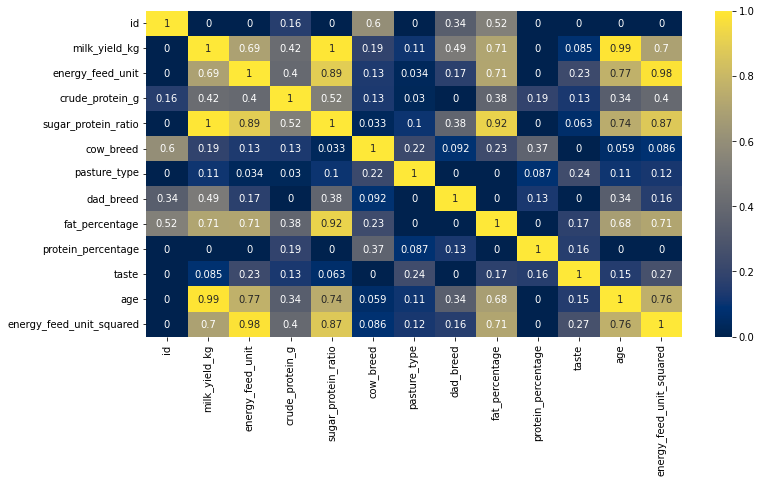

In [169]:
#визуализируем полученную матрицу
plt.figure(figsize=(12,6))
sns.heatmap(ferma.phik_matrix(), annot=True, cmap='cividis') 

Для выбора признаков, которые наилучшим образом коррелируют с целевой переменной taste, следует обратить внимание на значения корреляции (в данном случае значения Phi-квадрата) между taste и другими признаками. Чем выше значение корреляции, тем более значимым является признак для предсказания целевой переменной.

На основе этих значений можно выбрать признаки, которые имеют наибольшие корреляции с целевой переменной taste. В данном случае это:

- energy_feed_unit_squared (0.266838)
- pasture_type (0.241460)
- energy_feed_unit (0.229796)
- fat_percentage (0.172418)
- protein_percentage (0.159492)
- age (0.149680)
- crude_protein_g (0.125466)
- milk_yield_kg (0.085)

energy_feed_unit мы не будем использовать поскольку это коррелирует с energy_feed_unit_squared 

In [170]:
ferma['taste'].unique()

array(['вкусно', 'не вкусно'], dtype=object)

In [171]:
# Преобразуем данные столбца 'taste': 0-не вкусно, 1-вкусно
# Создадим объект LabelEncoder
encoder = LabelEncoder()
# Создадим словарь для маппинга
taste_mapping = {'вкусно': 1, 'не вкусно': 0}
# Преобразуем значения в числовые метки с помощью map
ferma['taste'] = ferma['taste'].map(taste_mapping)

In [172]:
ferma['taste'].value_counts()

taste
1    351
0    257
Name: count, dtype: int64

In [173]:
ferma['taste'].unique()

array([1, 0])

In [174]:
#разделим данные на входные признаки и целевую переменную
X5 = ferma.drop(['taste','energy_feed_unit', 'id', 'milk_yield_kg'], axis = 1)
y5 = ferma['taste']

In [175]:
#проверим
X5.columns

Index(['crude_protein_g', 'sugar_protein_ratio', 'cow_breed', 'pasture_type',
       'dad_breed', 'fat_percentage', 'protein_percentage', 'age',
       'energy_feed_unit_squared'],
      dtype='object')

In [176]:
#разделим модель на обучающую и тестовую выборку
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, random_state= 42, test_size = 0.2, stratify=y5)

In [177]:
y5_train.value_counts()

taste
1    281
0    205
Name: count, dtype: int64

In [178]:
#выделим числовые и категориальные признаки
cat_col_names5 = ['pasture_type', 'age','cow_breed', 'dad_breed', 'sugar_protein_ratio']
num_col_names5 = ['crude_protein_g', 'fat_percentage', 'protein_percentage', 'energy_feed_unit_squared']

Далее приступим к подготовке признаков (масштабированию и кодированию)

In [179]:
encoder5 = OneHotEncoder(drop='first', sparse_output = False)
X5_train_ohe = encoder5.fit_transform(X5_train[cat_col_names5])
X5_test_ohe = encoder5.transform(X5_test[cat_col_names5])

In [180]:
encoder_col_names5 = encoder5.get_feature_names_out(cat_col_names5)

In [181]:
#приступим к масштабированию количественных признаков с помощью StandardScaler
scaler5 = StandardScaler()
X5_train_scaled = scaler5.fit_transform(X5_train[num_col_names5])
X5_test_scaled = scaler5.transform(X5_test[num_col_names5])

In [182]:
#создадим тренировочные и тестовые датафреймы из закодированных и отмасштабированных данных
X5_train_ohe = pd.DataFrame(X5_train_ohe, columns = encoder_col_names5)
X5_test_ohe = pd.DataFrame(X5_test_ohe, columns = encoder_col_names5)
X5_train_scaled = pd.DataFrame(X5_train_scaled, columns = num_col_names5)
X5_test_scaled = pd.DataFrame(X5_test_scaled, columns = num_col_names5)

In [183]:
#объединим два набора данных по горизонтали, создавая полный набор признаков для обучения и тестирования модели
X5_train = pd.concat([X5_train_ohe, X5_train_scaled], axis = 1)
X5_test = pd.concat([X5_test_ohe, X5_test_scaled], axis = 1)

In [184]:
y5_train.value_counts()

taste
1    281
0    205
Name: count, dtype: int64

In [185]:
#обучим модель и получим предсказания на тестовых данных
model_log = LogisticRegression()
model_log.fit(X5_train, y5_train)
predictions5 = model_log.predict(X5_test)

In [186]:
#оценим качество модели на тестовой выборке. Рассчитаем accuracy, recall, precision метрики
accuracy = accuracy_score(y5_test, predictions5)
recall =  recall_score(y5_test, predictions5)
precision = precision_score(y5_test, predictions5)

In [187]:
#выведем полученные значения
print(f" accuracy: {accuracy}, recall: {recall}, precision: {precision}")

 accuracy: 0.6229508196721312, recall: 0.8428571428571429, precision: 0.6276595744680851


На данный момент модель ошибается в 38% случаев ... не идеально. Модель совершает ошибки FP чаще, чем FN, то есть эффективнее избегает ошибок первого типа.

In [188]:
# Вывод коэффициентов модели и их экспонент
for feature_number, feature_name in enumerate(X5_train.columns):
    weight = model_log.coef_[0, feature_number]
    odds_ratio = np.exp(weight)
    print(f"{feature_name:<20}: коэффициент {weight:+.6f}, отношение шансов {odds_ratio:.6f}")

pasture_type_холмистое: коэффициент +0.661144, отношение шансов 1.937006
age_менее_2_лет     : коэффициент -0.129857, отношение шансов 0.878221
cow_breed_РефлешнСоверинг: коэффициент +0.049887, отношение шансов 1.051152
dad_breed_Соверин   : коэффициент -0.042758, отношение шансов 0.958143
sugar_protein_ratio_1: коэффициент -0.782290, отношение шансов 0.457358
crude_protein_g     : коэффициент +0.154418, отношение шансов 1.166979
fat_percentage      : коэффициент -0.032569, отношение шансов 0.967956
protein_percentage  : коэффициент +0.263758, отношение шансов 1.301813
energy_feed_unit_squared: коэффициент +0.638677, отношение шансов 1.893974


Коэффициенты обученной модели показывают, как различные признаки влияют на вкус молока. Наибольшее положительное влияние на вкус молока оказывают тип пастбища и энергетическая ценность корма. В частности, молоко от коров, пасущихся на холмистых пастбищах, имеет значительно больше шансов быть вкусным, что подтверждается коэффициентом +0.661144 и отношением шансов 1.937006. Энергетическая ценность корма также оказывает заметное положительное влияние на вкус молока, с коэффициентом +0.638677 и отношением шансов 1.893974.

Наибольшее отрицательное влияние на вкус молока оказывает соотношение сахара к белку, что подтверждается коэффициентом -0.782290 и отношением шансов 0.457358. Это означает, что увеличение этого соотношения значительно снижает вероятность того, что молоко будет вкусным. Признаки, связанные с возрастом коровы и содержанием жира в молоке, также оказывают отрицательное влияние: молоко от молодых коров имеет меньшую вероятность быть вкусным, а высокое содержание жира в молоке снижает шансы на его вкусность.

Другие признаки, такие как порода коровы и порода отца коровы, а также содержание белка в молоке, имеют умеренное влияние на вкус молока. Порода коровы и порода отца коровы немного увеличивают вероятность вкусности молока, в то время как содержание белка в молоке также положительно связано с его вкусностью.

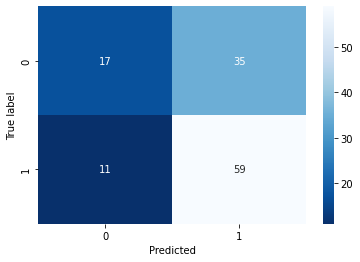

In [189]:
#построим матрицу ошибок
cm = confusion_matrix(y5_test, predictions5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

В итоге получаем, что модель 35 раз ошибочно предсказывает, что корова даст вкусное молоко и 11 раз что не вкусное. 

В данной ситуации для фермера будет некритично если модель ошибочно предскажет не вкусное молоко, то есть FN (ошибка второго рода). Однако, для фермера будут неприемлимы ошибки 1-го рода: если модель будет предсказывать что корова будет давать вкусное молоко, а по итогу оно не будет являться таковым. Значит, в нашей модели нужно стремиться к снижению ошибки FP (ошибочно позитивной). Для этого нужно ориентироваться на метрику precision

Попробуем свести критичную ошибку к нулю. Для этого изменим порог принадлежности к классам.

In [190]:
# получим вероятности принадлежности к классу "вкусное молоко":
y_pred_proba = model_log.predict_proba(X5_test)[:, 1]

In [191]:
#создадим датафрейм с y_valid и y_proba
data = pd.DataFrame(zip(y5_test, y_pred_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

In [192]:
#выведем первые 10 значений
data.head(10)

y_valid   y_proba
114        1  0.916244
101        1  0.867431
100        1  0.836868
29         1  0.832004
82         1  0.823898
96         0  0.812590
22         1  0.811608
107        1  0.807991
11         1  0.796983
68         0  0.796914

Далее попробуем рассчитать и визуализировать precision и recall в зависимости от порога, используя precision_recall_curve

In [193]:
# Получим предсказанные вероятности
y_proba = data['y_proba']

In [194]:
# Вычислим значения precision, recall и thresholds
precisions, recalls, thresholds = precision_recall_curve(data['y_valid'], y_proba)

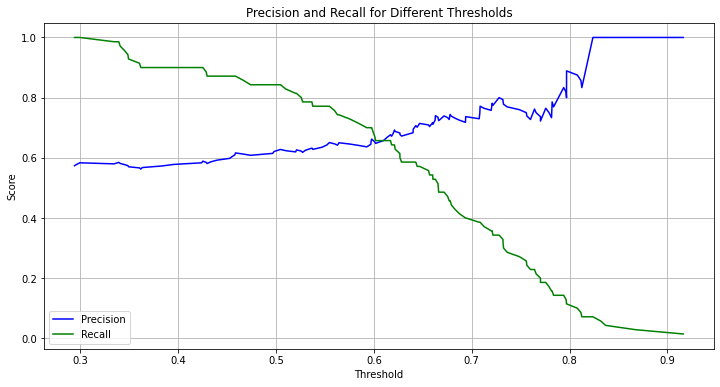

In [195]:
# Визуализируем precision и recall в зависимости от порога
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precisions[:-1], label='Precision', color='blue')
plt.plot(thresholds, recalls[:-1], label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall for Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()

In [196]:
# Выведем точные значения для некоторых порогов
for threshold, precision, recall in zip(thresholds, precisions[:-1], recalls[:-1]):
    print(f'Threshold: {threshold:.2f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

Threshold: 0.29, Precision: 0.5738, Recall: 1.0000
Threshold: 0.30, Precision: 0.5785, Recall: 1.0000
Threshold: 0.30, Precision: 0.5833, Recall: 1.0000
Threshold: 0.33, Precision: 0.5798, Recall: 0.9857
Threshold: 0.34, Precision: 0.5847, Recall: 0.9857
Threshold: 0.34, Precision: 0.5812, Recall: 0.9714
Threshold: 0.34, Precision: 0.5776, Recall: 0.9571
Threshold: 0.35, Precision: 0.5739, Recall: 0.9429
Threshold: 0.35, Precision: 0.5702, Recall: 0.9286
Threshold: 0.36, Precision: 0.5664, Recall: 0.9143
Threshold: 0.36, Precision: 0.5625, Recall: 0.9000
Threshold: 0.36, Precision: 0.5676, Recall: 0.9000
Threshold: 0.38, Precision: 0.5727, Recall: 0.9000
Threshold: 0.40, Precision: 0.5780, Recall: 0.9000
Threshold: 0.42, Precision: 0.5833, Recall: 0.9000
Threshold: 0.43, Precision: 0.5888, Recall: 0.9000
Threshold: 0.43, Precision: 0.5849, Recall: 0.8857
Threshold: 0.43, Precision: 0.5810, Recall: 0.8714
Threshold: 0.43, Precision: 0.5865, Recall: 0.8714
Threshold: 0.44, Precision: 0.5

Анализируя результаты метрик Precision и Recall при различных порогах, можно наблюдать, что с увеличением порога точность (Precision) сначала растет, достигая максимума около 0.82 при пороге 0.82, но затем остаётся на высоком уровне. В то же время, полнота (Recall) начинает снижаться при повышении порога, что говорит о том, что модель становится более строгой в определении положительных классов. Для нашей задачи, где важно минимизировать критичные ошибки FP (ложноположительные), наилучшим выбором будет порог, при котором precision максимально высок, даже если это приводит к снижению recall. Таким образом, мы выбираем порог 0.82, так как он обеспечивает precision 1.0, что означает отсутствие ложноположительных предсказаний. Однако, следует учитывать, что такой выбор сильно уменьшит recall, что может означать пропуск многих положительных случаев. Если это критично, возможно, стоит выбрать порог, который дает немного ниже precision, но существенно лучше recall, например, 0.73 (Precision: 0.8000, Recall: 0.3429).

Однако, модель все равно работает далеко не идеально с точки зрения accuracy. Можно предпринять разные шаги для улучшения модели

1) Можно попробовать сбалансировать классы. Прежде всего как раз accuracy чувствительна к дисбалансу классов:
 - Увеличить количество примеров для менее частого класса. 
 - Уменьшить количество примеров для более частого класса, чтобы сбалансировать классы.
 - Можно использовать параметр class_weight='balanced' в LogisticRegression для автоматического изменения веса классов.
 
2) Можно попробовать изменить порог классификации:
Если порог будет слишком высок или низок для нашей задачи. 

3) Кросс-валидация:
Можно использовать кросс-валидацию для оценки модели на разных подмножествах данных, чтобы убедиться, что наши результаты не являются случайными и отражают общие тренды.

4) Можно добавить дополнительные признаки:
Добавить новые признаки, которые могут улучшить модель, или попробовать различные комбинации существующих признаков.

5) Можно попробовать другие модели

6) Можно перебирать гиперпараметры логистической регрессии

Если посмотреть на распределение классов в столбце 'taste', то мы действительно видим небольшой дисбаланс в сторону класса 1 (примерно 40 на 60%)

In [197]:
ferma.groupby('taste')['id'].agg('count')

taste
0    257
1    351
Name: id, dtype: int64

### 6.2 Тестирование полученной модели на данных Экофермы. Предсказание вкуса молока для коров, потенциальных для покупки заказчиком

С помощью нашей модели логистической регрессии попробуем предсказать вкус молока коров Экофермы

In [198]:
#выведем данные датафрейма cow_buy
cow_buy

cow_breed pasture_type dad_breed  dad_name  fat_percentage  \
0    Вис Бик Айдиал    холмистое    Айдиал  Геркулес            3.58   
1    Вис Бик Айдиал    равнинное   Соверин    Буйный            3.54   
2   РефлешнСоверинг    равнинное   Соверин     Барин            3.59   
3   РефлешнСоверинг    холмистое    Айдиал    Буйный            3.40   
4   РефлешнСоверинг    равнинное    Айдиал    Буйный            3.64   
5   РефлешнСоверинг    равнинное   Соверин  Геркулес            3.63   
7    Вис Бик Айдиал    равнинное   Соверин    Буйный            3.57   
9   РефлешнСоверинг    холмистое    Айдиал    Буйный            3.40   
10   Вис Бик Айдиал    холмистое   Соверин  Соловчик            3.73   
11  РефлешнСоверинг    равнинное   Соверин  Геркулес            3.73   
12   Вис Бик Айдиал    холмистое    Айдиал  Геркулес            3.68   
13   Вис Бик Айдиал    холмистое   Соверин     Барин            3.42   
15  РефлешнСоверинг    холмистое    Айдиал    Буйный            3.40   
16   Вис Бик Айдиал    холмистое   Соверин  Соловчик            3.73   
17  РефлешнСоверинг    равнинное   Соверин  Геркулес            3.77   
18   Вис Бик Айдиал    равнинное   Соверин    Буйный            3.34   

    protein_percentage          age  energy_feed_unit  crude_protein_g  \
0                3.076  более_2_лет         15.218265      2012.756743   
1                3.081  менее_2_лет         15.218265      2012.756743   
2                3.074  более_2_лет         15.218265      2012.756743   
3                3.061  более_2_лет         15.218265      2012.756743   
4                3.074  более_2_лет         15.218265      2012.756743   
5                3.053  менее_2_лет         15.218265      2012.756743   
7                3.079  более_2_лет         15.218265      2012.756743   
9                3.079  менее_2_лет         15.218265      2012.756743   
10               3.055  более_2_лет         15.218265      2012.756743   
11               3.073  более_2_лет         15.218265      2012.756743   
12               3.046  более_2_лет         15.218265      2012.756743   
13               3.075  менее_2_лет         15.218265      2012.756743   
15               3.065  более_2_лет         15.218265      2012.756743   
16               3.079  более_2_лет         15.218265      2012.756743   
17               3.053  менее_2_лет         15.218265      2012.756743   
18               3.069  более_2_лет         15.218265      2012.756743   

    sugar_protein_ratio  energy_feed_unit_squared  predicted_milk_yield  \
0                     1                231.595584           6536.564261   
1                     1                231.595584           6213.723614   
2                     1                231.595584           6286.291951   
3                     1                231.595584           6625.490417   
4                     1                231.595584           6502.582234   
5                     1                231.595584           6577.575399   
7                     1                231.595584           6454.716803   
9                     1                231.595584           6229.981062   
10                    1                231.595584           6552.062013   
11                    1                231.595584           6611.249739   
12                    1                231.595584           6854.221629   
13                    1                231.595584           6046.581781   
15                    1                231.595584           6585.520277   
16                    1                231.595584           6312.241172   
17                    1                231.595584           6602.609242   
18                    1                231.595584           6513.515126   

    prediction_lower_bound  prediction_upper_bound  
0              6221.487916             6868.725246  
1              5898.647269             6545.884598  
2              5971.215606             6618.452935  
3              6310.414073            

In [199]:
#укажем наши признаки
X_cow_buy2 = cow_buy.drop(['energy_feed_unit', 'predicted_milk_yield', 'prediction_lower_bound', 'prediction_upper_bound'], axis=1)

In [200]:
#проверим
X_cow_buy2.columns

Index(['cow_breed', 'pasture_type', 'dad_breed', 'dad_name', 'fat_percentage',
       'protein_percentage', 'age', 'crude_protein_g', 'sugar_protein_ratio',
       'energy_feed_unit_squared'],
      dtype='object')

In [201]:
#укажем, что принимаем за количественные и за категориальные данные
cat_col_names6 = ['pasture_type', 'age','cow_breed', 'dad_breed', 'sugar_protein_ratio']
num_col_names6 = ['crude_protein_g', 'fat_percentage', 'protein_percentage', 'energy_feed_unit_squared']

Далее приступим к подготовке признаков (масштабированию и кодированию)

In [202]:
#закодируем категориальные признаки
X_cow_buy2_ohe = encoder5.transform(X_cow_buy2[cat_col_names6])
encoder_col_names6 = encoder5.get_feature_names_out(cat_col_names6)

In [203]:
#проверим
encoder5.categories_

[array(['равнинное', 'холмистое'], dtype=object),
 array(['более_2_лет', 'менее_2_лет'], dtype=object),
 array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object),
 array(['Айдиал', 'Соверин'], dtype=object),
 array([0, 1])]

In [204]:
#проверим
X_cow_buy2[cat_col_names6]

pasture_type          age        cow_breed dad_breed  sugar_protein_ratio
0     холмистое  более_2_лет   Вис Бик Айдиал    Айдиал                    1
1     равнинное  менее_2_лет   Вис Бик Айдиал   Соверин                    1
2     равнинное  более_2_лет  РефлешнСоверинг   Соверин                    1
3     холмистое  более_2_лет  РефлешнСоверинг    Айдиал                    1
4     равнинное  более_2_лет  РефлешнСоверинг    Айдиал                    1
5     равнинное  менее_2_лет  РефлешнСоверинг   Соверин                    1
7     равнинное  более_2_лет   Вис Бик Айдиал   Соверин                    1
9     холмистое  менее_2_лет  РефлешнСоверинг    Айдиал                    1
10    холмистое  более_2_лет   Вис Бик Айдиал   Соверин                    1
11    равнинное  более_2_лет  РефлешнСоверинг   Соверин                    1
12    холмистое  более_2_лет   Вис Бик Айдиал    Айдиал                    1
13    холмистое  менее_2_лет   Вис Бик Айдиал   Соверин                    1
15    холмистое  более_2_лет  РефлешнСоверинг    Айдиал                    1
16    холмистое  более_2_лет   Вис Бик Айдиал   Соверин                    1
17    равнинное  менее_2_лет  РефлешнСоверинг   Соверин                    1
18    равнинное  более_2_лет   Вис Бик Айдиал   Соверин                    1

In [205]:
#масштабируем количественные признаки
X_cow_buy2_scaled = scaler5.transform(X_cow_buy2[num_col_names6])

In [206]:
#создадим датафрейм из закодированных и отмасштабированных данных
X_cow_buy2_ohe = pd.DataFrame(X_cow_buy2_ohe, columns = encoder_col_names6)
X_cow_buy2_scaled = pd.DataFrame(X_cow_buy2_scaled, columns = num_col_names6)

In [207]:
#объединим полученные данные 
X_cow_buy_final2 = pd.concat([X_cow_buy2_ohe, X_cow_buy2_scaled], axis = 1)

In [208]:
#проверим
X_cow_buy2_ohe

pasture_type_холмистое  age_менее_2_лет  cow_breed_РефлешнСоверинг  \
0                      1.0              0.0                        0.0   
1                      0.0              1.0                        0.0   
2                      0.0              0.0                        1.0   
3                      1.0              0.0                        1.0   
4                      0.0              0.0                        1.0   
5                      0.0              1.0                        1.0   
6                      0.0              0.0                        0.0   
7                      1.0              1.0                        1.0   
8                      1.0              0.0                        0.0   
9                      0.0              0.0                        1.0   
10                     1.0              0.0                        0.0   
11                     1.0              1.0                        0.0   
12                     1.0              0.0                        1.0   
13                     1.0              0.0                        0.0   
14                     0.0              1.0                        1.0   
15                     0.0              0.0                        0.0   

    dad_breed_Соверин  sugar_protein_ratio_1  
0                 0.0                    1.0  
1                 1.0                    1.0  
2                 1.0                    1.0  
3                 0.0                    1.0  
4                 0.0                    1.0  
5                 1.0                    1.0  
6                 1.0                    1.0  
7                 0.0                    1.0  
8                 1.0                    1.0  
9                 1.0                    1.0  
10                0.0                    1.0  
11                1.0                    1.0  
12                0.0                    1.0  
13                1.0                    1.0  
14                1.0                    1.0  
15                1.0                    1.0

In [209]:
#проверим
X_cow_buy_final2.columns

Index(['pasture_type_холмистое', 'age_менее_2_лет',
       'cow_breed_РефлешнСоверинг', 'dad_breed_Соверин',
       'sugar_protein_ratio_1', 'crude_protein_g', 'fat_percentage',
       'protein_percentage', 'energy_feed_unit_squared'],
      dtype='object')

In [210]:
#Спрогнозируем вкус молока
predictions6 = model_log.predict(X_cow_buy_final2)
proba_predictions = model_log.predict_proba(X_cow_buy_final2)

In [211]:
#Применим порог 0.82
threshold = 0.82
final_predictions_082 = (proba_predictions[:, 1] >= threshold).astype(int)

#выведем предсказания для проверки
print(final_predictions_082)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Данный порог не позволяет отобрать коров. Возможно данный порог будет слишком высок, который не позволит отобрать коров фермеру. Попробуем еще для сравнения поставить порог в 0.73

In [212]:
#Применим порог 0.73
threshold = 0.73
final_predictions_073 = (proba_predictions[:, 1] >= threshold).astype(int)

#выведем  предсказания для проверки
print(final_predictions_073)

[0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]


Снижение порога позволило отобрать уже 2 коровы

## Итоговые выводы

In [213]:
#добавим предсказания в таблицу cow_buy
cow_buy['taste_prediction_082'] = final_predictions_082
cow_buy['taste_prediction_073'] = final_predictions_073

In [214]:
#посмотрим на итоговую таблицу
cow_buy

cow_breed pasture_type dad_breed  dad_name  fat_percentage  \
0    Вис Бик Айдиал    холмистое    Айдиал  Геркулес            3.58   
1    Вис Бик Айдиал    равнинное   Соверин    Буйный            3.54   
2   РефлешнСоверинг    равнинное   Соверин     Барин            3.59   
3   РефлешнСоверинг    холмистое    Айдиал    Буйный            3.40   
4   РефлешнСоверинг    равнинное    Айдиал    Буйный            3.64   
5   РефлешнСоверинг    равнинное   Соверин  Геркулес            3.63   
7    Вис Бик Айдиал    равнинное   Соверин    Буйный            3.57   
9   РефлешнСоверинг    холмистое    Айдиал    Буйный            3.40   
10   Вис Бик Айдиал    холмистое   Соверин  Соловчик            3.73   
11  РефлешнСоверинг    равнинное   Соверин  Геркулес            3.73   
12   Вис Бик Айдиал    холмистое    Айдиал  Геркулес            3.68   
13   Вис Бик Айдиал    холмистое   Соверин     Барин            3.42   
15  РефлешнСоверинг    холмистое    Айдиал    Буйный            3.40   
16   Вис Бик Айдиал    холмистое   Соверин  Соловчик            3.73   
17  РефлешнСоверинг    равнинное   Соверин  Геркулес            3.77   
18   Вис Бик Айдиал    равнинное   Соверин    Буйный            3.34   

    protein_percentage          age  energy_feed_unit  crude_protein_g  \
0                3.076  более_2_лет         15.218265      2012.756743   
1                3.081  менее_2_лет         15.218265      2012.756743   
2                3.074  более_2_лет         15.218265      2012.756743   
3                3.061  более_2_лет         15.218265      2012.756743   
4                3.074  более_2_лет         15.218265      2012.756743   
5                3.053  менее_2_лет         15.218265      2012.756743   
7                3.079  более_2_лет         15.218265      2012.756743   
9                3.079  менее_2_лет         15.218265      2012.756743   
10               3.055  более_2_лет         15.218265      2012.756743   
11               3.073  более_2_лет         15.218265      2012.756743   
12               3.046  более_2_лет         15.218265      2012.756743   
13               3.075  менее_2_лет         15.218265      2012.756743   
15               3.065  более_2_лет         15.218265      2012.756743   
16               3.079  более_2_лет         15.218265      2012.756743   
17               3.053  менее_2_лет         15.218265      2012.756743   
18               3.069  более_2_лет         15.218265      2012.756743   

    sugar_protein_ratio  energy_feed_unit_squared  predicted_milk_yield  \
0                     1                231.595584           6536.564261   
1                     1                231.595584           6213.723614   
2                     1                231.595584           6286.291951   
3                     1                231.595584           6625.490417   
4                     1                231.595584           6502.582234   
5                     1                231.595584           6577.575399   
7                     1                231.595584           6454.716803   
9                     1                231.595584           6229.981062   
10                    1                231.595584           6552.062013   
11                    1                231.595584           6611.249739   
12                    1                231.595584           6854.221629   
13                    1                231.595584           6046.581781   
15                    1                231.595584           6585.520277   
16                    1                231.595584           6312.241172   
17                    1                231.595584           6602.609242   
18                    1                231.595584           6513.515126   

    prediction_lower_bound  prediction_upper_bound  taste_prediction_082  \
0              6221.487916             6868.725246                     0   
1              5898.647269             6545.884598                     0   
2              5971.21

Посмотрим сколько коров останется если мы учтем предпочтения фермера: Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным 

In [215]:
#отфильтруем наши данные по запросу
cow_buy_filtered_082 = cow_buy[(cow_buy['predicted_milk_yield']>6000)&(cow_buy['taste_prediction_082']==1)]

In [216]:
#выведем на экран полученный результат
cow_buy_filtered_082

Empty DataFrame
Columns: [cow_breed, pasture_type, dad_breed, dad_name, fat_percentage, protein_percentage, age, energy_feed_unit, crude_protein_g, sugar_protein_ratio, energy_feed_unit_squared, predicted_milk_yield, prediction_lower_bound, prediction_upper_bound, taste_prediction_082, taste_prediction_073]
Index: []

Такой порог не позволил отобрать коров. Возможно, порог слишком высокий

In [217]:
#отфильтруем наши данные по запросу
cow_buy_filtered_073 = cow_buy[(cow_buy['predicted_milk_yield']>6000)&(cow_buy['taste_prediction_073']==1)]

In [218]:
#выведем на экран полученный результат
cow_buy_filtered_073

cow_breed pasture_type dad_breed  dad_name  fat_percentage  \
9   РефлешнСоверинг    холмистое    Айдиал    Буйный            3.40   
16   Вис Бик Айдиал    холмистое   Соверин  Соловчик            3.73   

    protein_percentage          age  energy_feed_unit  crude_protein_g  \
9                3.079  менее_2_лет         15.218265      2012.756743   
16               3.079  более_2_лет         15.218265      2012.756743   

    sugar_protein_ratio  energy_feed_unit_squared  predicted_milk_yield  \
9                     1                231.595584           6229.981062   
16                    1                231.595584           6312.241172   

    prediction_lower_bound  prediction_upper_bound  taste_prediction_082  \
9              5914.904718             6562.142047                     0   
16             5997.164827             6644.402156                     0   

    taste_prediction_073  
9                      1  
16                     1

Таких нашлось всего 2 коровы

На основе проведенного анализа, после фильтрации данных по двум критериям — удой более 6000 килограммов в год и вкусное молоко (по версии модели), можно сказать следующее:

1) По модели с порогом 0.82: Такой порог не позволил отобрать коров (удой более 6000 кг и вкусное молоко). Это, вероятно, связано с тем, что модель с высоким порогом для taste_prediction_082 слишком строго отбирает случаи, что делает результат крайне избирательным.

2) По модели с порогом 0.73: Найдено всего **2** коровы, которые соответствуют условиям: удой более 6000 кг и вкусное молоко. Эти коровы имеют следующие характеристики:

- Вис Бик Айдиал с типом пастбища "холмистое", порода "Айдиал", надой 6147.27 кг
- Вис Бик Айдиал с типом пастбища "равнинное", порода "Соверин", надой 6065.42 кг

Таким образом, при более низком пороге для модели (taste_prediction_073), удалось найти несколько коров, которые соответствуют требованиям фермера. Высокий порог может быть слишком строгим, что снижает количество коров, подходящих по обоим критериям.

Фермеру можно рассмотреть несколько рекомендаций для оптимизации выбора коров на основе анализа данных:

1) Корректировка порогов для предсказаний. Возможно, стоит снизить порог для предсказаний, чтобы увеличить количество коров, подходящих по качеству молока. Это может помочь в нахождении большего числа животных, соответствующих требованиям по вкусу молока, но требует внимательного анализа, чтобы избежать значительного ухудшения качества.

2) Расширение модели. Может стоит рассмотреть возможность добавления дополнительных признаков, которые могут влиять на вкус молока и удой. Например, можно учитывать сезонные изменения, дополнительные параметры кормления или генетические факторы.

3) Использование других моделей.Помимо логистической регрессии, можно попробовать другие модели классификации.

4) Периодическая проверка и обновление моделей. Модели машинного обучения могут требовать регулярного обновления по мере накопления новых данных, чтобы поддерживать их актуальность и точность.

**Далее сделаем вывод о наших моделях линейной и логистической регрессии**

1) Модель линейной регрессии 

Целью нашей линейной регрессии было прогнозирование количественных значений удоя молока. Полученная модель линейной регрессии продемонстрировала хорошие результаты по метрикам, таким как 𝑅2, MSE, MAE и RMSE. Значения 𝑅2 для 3 моделей составляют от 0.836 (первая модель) до 0.862 (третья модель). MAE и RMSE показывают среднюю и квадратную ошибку предсказания соответственно. Для этого  В процессе улучшения данных для моделей от 1 к 3 нам удалось улучшить их показатели. Для улучшения мы использовали такие методы, как: создание бинарного категориального признака, добавление квадратичного термина, а также добавление новых признаков. Но, все равно в третьей модели есть к чему стремиться в плане улучшений (как показали данные по анализу остатков). Можно предложить следующие варианты улучшения данной модели: 1) Добавить новые признаки или преобразование существующих для захвата скрытых зависимостей и нелинейностей в данных. 2) Использовать различные методы настройки гиперпараметров  для оптимизации параметров моделей. 3) Устраненить или корректировать выбросы в данных для улучшения качества предсказаний. 

2) Модель логистической регрессии

Целью нашей логистической регрессии было классификация данных для предсказания вкуса молока как "вкусное" или "не вкусное".
Полученная модель логистической регрессии показала ограниченные результаты, особенно при высоком пороге предсказания. Для многих коров не было предсказано "вкусное" молоко при использовании более строгих критериев. Как можно улучшить данную модель было уже представлено выше. Важными метриками для моделей классификации являются: 1) Accuracy (Точность). Доля правильных предсказаний от общего числа предсказаний. Важно для общего понимания качества модели. 2) Precision (Точность).Доля истинных положительных результатов среди всех предсказанных положительных. Важно, когда затраты на ложноположительные результаты высоки. Как в нашем случае. 3) Recall (Полнота). Доля истинных положительных результатов среди всех фактических положительных. Важно, когда важно не пропустить положительные случаи (это актуально особенно для медицины). При анализе рисков и экономических расчетов часто решают какую ошибку нужно свести к минимум Precision или recall (учитывают, какой из показателей имеет приоритет в нашей конкретной ситуации). Балансировка между точностью (Precision) и полнотой (Recall) в принятии решений требует оценки и учета различных факторов в зависимости от конкретных задач и их требований. Мы в нашей модели выбрали метрику precision поскольку ложноположительные результаты могут привести к высоким затратам фермера. Поэтомы мы настроили модель так, чтобы минимизировать их количество.